In [20]:
from utils.dataloader import FifaStatDatabase
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [21]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

In [22]:
db = FifaStatDatabase('FifaStat.sqlite')

# Q1

Analyze home field advantage across different leagues and seasons: Does playing at home provide a statistically significant advantage, and has this advantage changed over time (2010-2015)?

In [23]:
df_match_denorm = db.execute_query_df("""
    SELECT m.season, m.home_team_goal, m.away_team_goal, l.name as league_name, c.name as country_name, 
           t_home.team_long_name as home_team_name, t_away.team_long_name as away_team_name
    FROM Match m
    LEFT JOIN League l ON m.league_id = l.id
    LEFT JOIN Country c ON m.country_id = c.id
    LEFT JOIN Team t_home ON m.home_team_api_id = t_home.team_api_id
    LEFT JOIN Team t_away ON m.away_team_api_id = t_away.team_api_id
""")
df_match_denorm

season  home_team_goal  away_team_goal               league_name  \
0      2008/2009               1               1    Belgium Jupiler League   
1      2008/2009               0               0    Belgium Jupiler League   
2      2008/2009               0               3    Belgium Jupiler League   
3      2008/2009               5               0    Belgium Jupiler League   
4      2008/2009               1               3    Belgium Jupiler League   
...          ...             ...             ...                       ...   
25974  2015/2016               1               0  Switzerland Super League   
25975  2015/2016               1               2  Switzerland Super League   
25976  2015/2016               2               0  Switzerland Super League   
25977  2015/2016               0               0  Switzerland Super League   
25978  2015/2016               4               3  Switzerland Super League   

      country_name           home_team_name     away_team_name  
0          Belgium                 KRC Genk       Beerschot AC  
1          Belgium         SV Zulte-Waregem   Sporting Lokeren  
2          Belgium        KSV Cercle Brugge     RSC Anderlecht  
3          Belgium                 KAA Gent          RAEC Mons  
4          Belgium            FCV Dender EH  Standard de Liège  
...            ...                      ...                ...  
25974  Switzerland            FC St. Gallen            FC Thun  
25975  Switzerland                 FC Vaduz          FC Luzern  
25976  Switzerland  Grasshopper Club Zürich            FC Sion  
25977  Switzerland                   Lugano          FC Zürich  
25978  Switzerland           BSC Young Boys           FC Basel  

[25979 rows x 7 columns]

In [24]:
df_match_denorm['WinLossDraw'] = df_match_denorm.apply(lambda x: 'Home Win' if x['home_team_goal'] > x['away_team_goal'] else ('Away Win' if x['home_team_goal'] < x['away_team_goal'] else 'Draw'), axis=1)
df_match_denorm['WinLossDraw'].value_counts() / df_match_denorm['WinLossDraw'].count() * 100

WinLossDraw
Home Win    45.871666
Away Win    28.738597
Draw        25.389738
Name: count, dtype: float64

In [25]:
# Nan verify
df_match_denorm.isna().sum()

season            0
home_team_goal    0
away_team_goal    0
league_name       0
country_name      0
home_team_name    0
away_team_name    0
WinLossDraw       0
dtype: int64

In [26]:
# Calculate home and away win rates by team
team_stats = pd.DataFrame()

# Home win rates
home_wins = df_match_denorm[df_match_denorm['WinLossDraw']
                            == 'Home Win']['home_team_name'].value_counts()
home_total = df_match_denorm['home_team_name'].value_counts()
home_win_rates = (home_wins / home_total).fillna(0)

# Away win rates
away_wins = df_match_denorm[df_match_denorm['WinLossDraw']
                            == 'Away Win']['away_team_name'].value_counts()
away_total = df_match_denorm['away_team_name'].value_counts()
away_win_rates = (away_wins / away_total).fillna(0)

# Create dataframe for plotting
team_stats['home_win_rate'] = home_win_rates
team_stats['away_win_rate'] = away_win_rates

Text(0, 0.5, 'Away Win Rate')

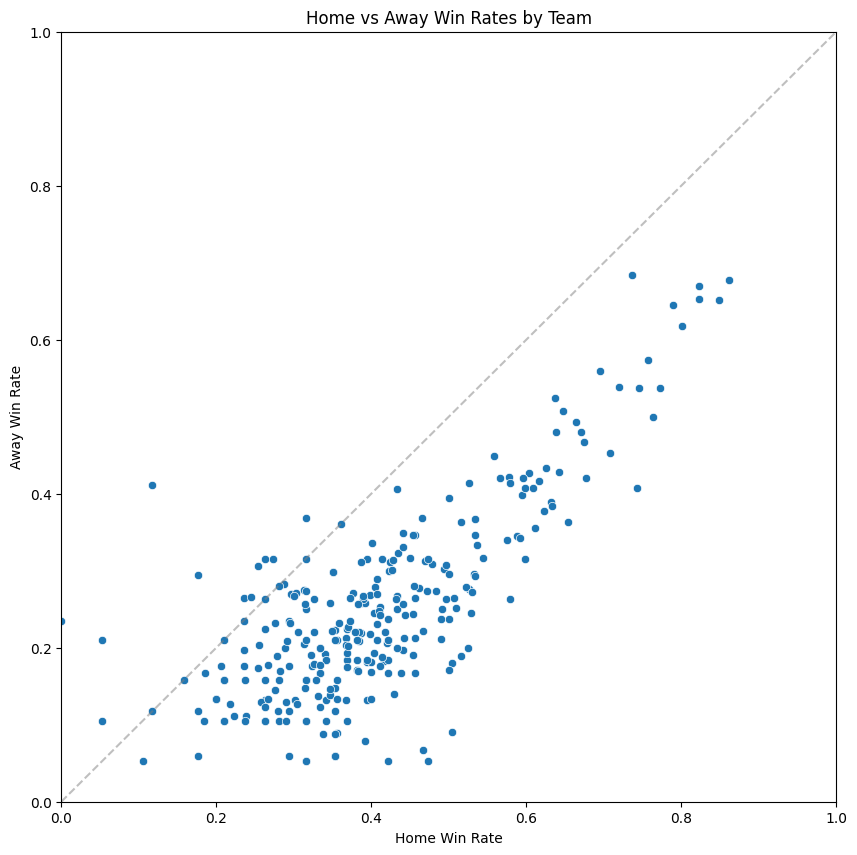

In [27]:
import seaborn as sns

import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))

# Add y=x line
plt.plot([0, 1], [0, 1], '--', color='gray', alpha=0.5)

# Create scatter plot with team names
sns.scatterplot(data=team_stats, x='home_win_rate', y='away_win_rate')

# Add team names as annotations
# for idx in team_stats.index:
#     plt.annotate(idx,
#                  (team_stats.loc[idx, 'home_win_rate'],
#                   team_stats.loc[idx, 'away_win_rate']),
#                  xytext=(5, 5), textcoords='offset points',
#                  fontsize=6)

plt.title('Home vs Away Win Rates by Team')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Home Win Rate')
plt.ylabel('Away Win Rate')

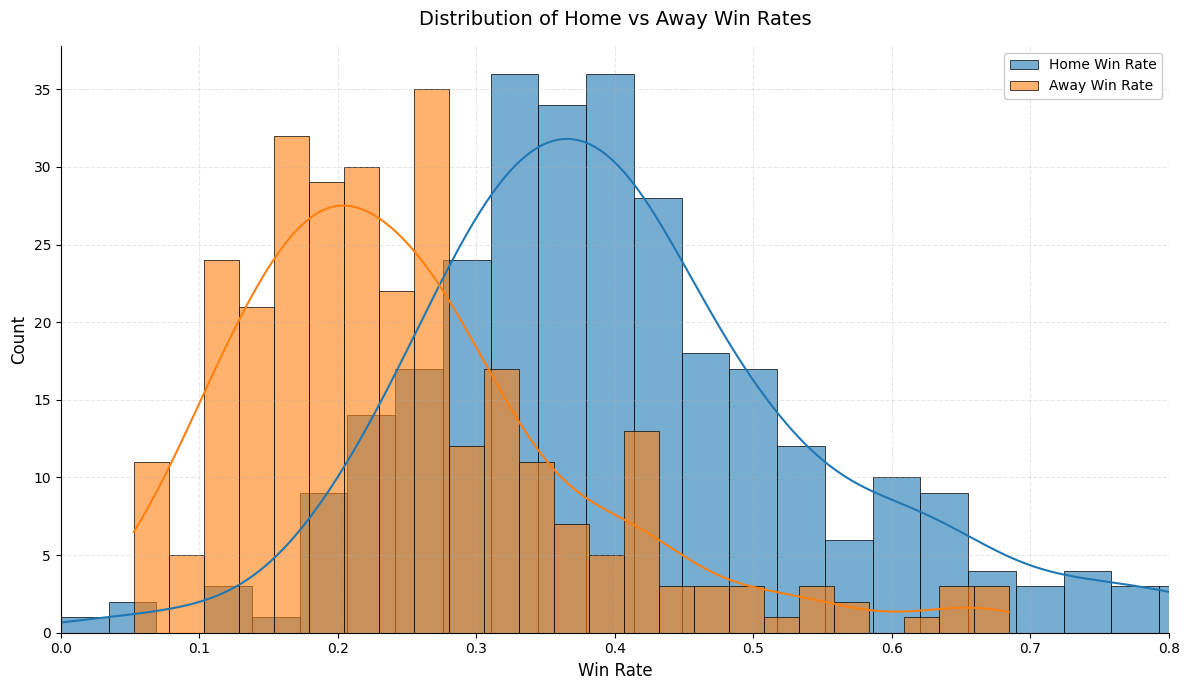

In [28]:
plt.figure(figsize=(12, 7))

# # Set style
# plt.style.use('seaborn')

# Create KDE plots with better colors and styling
sns.histplot(data=team_stats['home_win_rate'], label='Home Win Rate',
             bins=25, fill=True, alpha=0.6, kde=True, linewidth=0.5)
sns.histplot(data=team_stats['away_win_rate'], label='Away Win Rate',
             bins=25, fill=True, alpha=0.6, kde=True, linewidth=0.5)

# Customize the plot
plt.title('Distribution of Home vs Away Win Rates', fontsize=14, pad=15)
plt.xlabel('Win Rate', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Customize legend
plt.legend(frameon=True, facecolor='white', framealpha=1, fontsize=10)

# Add grid and customize its appearance
plt.grid(True, alpha=0.3, linestyle='--')

# Set x-axis limits for better visualization
plt.xlim(0, 0.8)

# Remove top and right spines
sns.despine()

# Adjust layout
plt.tight_layout()

In [29]:
from scipy import stats

# Perform paired t-test
t_stat, p_value = stats.ttest_rel(team_stats['home_win_rate'], team_stats['away_win_rate'])

print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4e}")
# Check if the difference is statistically significant at α = 0.05
if p_value < 0.05:
    print("There is a statistically significant difference between home and away win rates")
else:
    print("No significant difference between home and away win rates")
print("\nMedian win rates:")
print(f"Home: {team_stats['home_win_rate'].median():.4f}")
print(f"Away: {team_stats['away_win_rate'].median():.4f}")

t-statistic: 28.6036
p-value: 4.6152e-87
There is a statistically significant difference between home and away win rates

Median win rates:
Home: 0.3856
Away: 0.2229


<Figure size 1200x600 with 0 Axes>

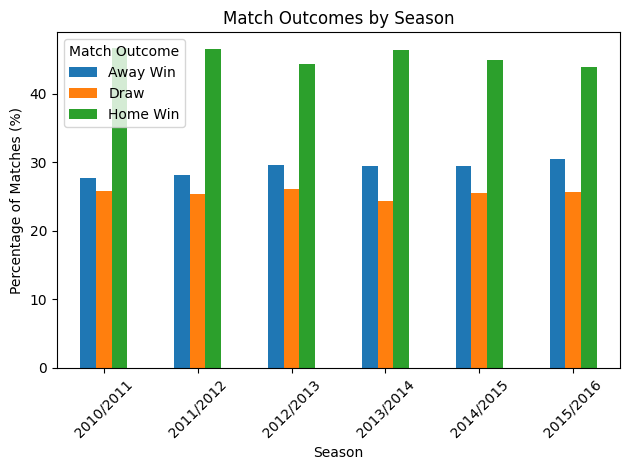

In [30]:
# Calculate the percentage of each outcome per season
season_outcomes = pd.crosstab(df_match_denorm['season'], df_match_denorm['WinLossDraw'], normalize='index') * 100

# Create a bar plot
plt.figure(figsize=(12, 6))
season_outcomes.iloc[2:, :].plot(kind='bar', stacked=False)

plt.title('Match Outcomes by Season')
plt.xlabel('Season')
plt.ylabel('Percentage of Matches (%)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend(title='Match Outcome')

# Adjust layout to prevent label cutoff
plt.tight_layout()

<Figure size 1500x800 with 0 Axes>

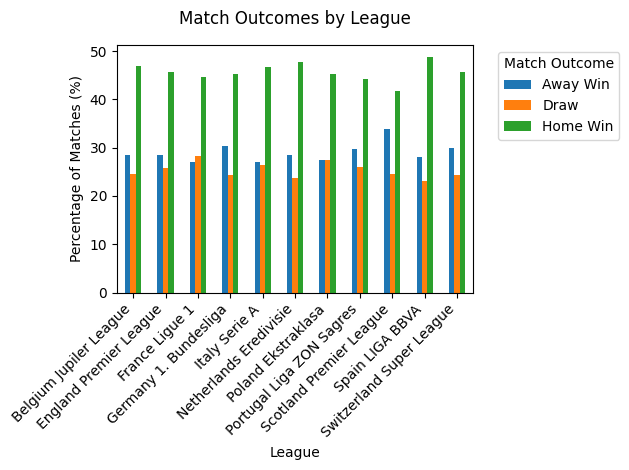

In [31]:
# Calculate win/loss/draw rates for each league
league_outcomes = pd.crosstab(df_match_denorm['league_name'], 
                            df_match_denorm['WinLossDraw'], 
                            normalize='index') * 100

# Create a bar plot
plt.figure(figsize=(15, 8))
league_outcomes.plot(kind='bar', stacked=False)

plt.title('Match Outcomes by League', fontsize=12, pad=15)
plt.xlabel('League', fontsize=10)
plt.ylabel('Percentage of Matches (%)', fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add legend
plt.legend(title='Match Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

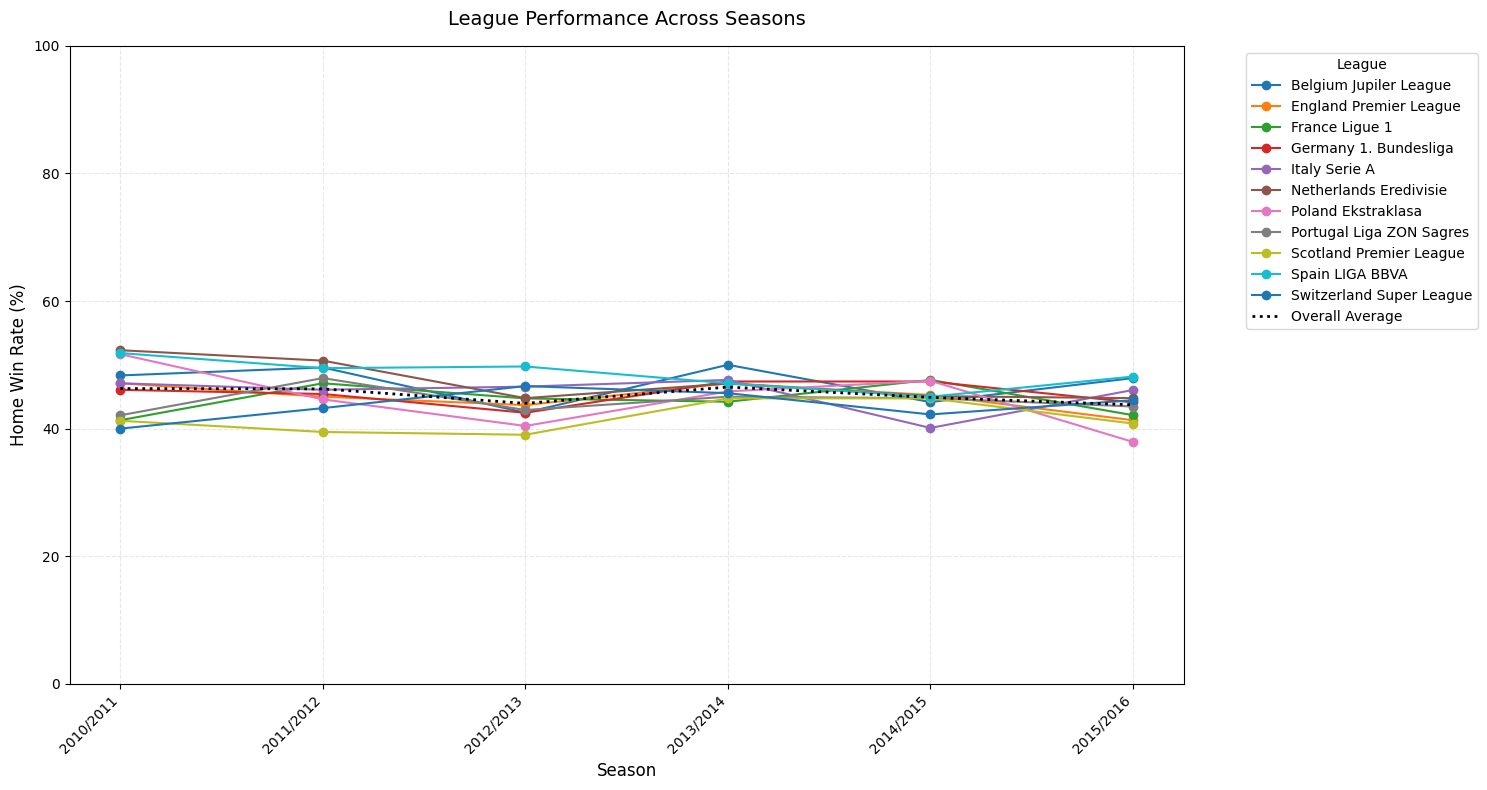

In [32]:
# Create pivot table for league performance by season
league_season_data = df_match_denorm.pivot_table(
    index='league_name',
    columns='season',
    values='WinLossDraw',
    aggfunc=lambda x: (x == 'Home Win').mean() * 100
)

league_season_data = league_season_data.iloc[:, 2:]

# Create the plot
plt.figure(figsize=(15, 8))

# Plot lines for each league
for league in league_season_data.index:
    plt.plot(league_season_data.columns,
             league_season_data.loc[league],
             marker='o',
             label=league)

# Calculate and plot overall season averages
season_averages = league_season_data.mean()
plt.plot(league_season_data.columns, 
         season_averages, 
         'k:',  # black dotted line
         linewidth=2, 
         label='Overall Average')

# Customize the plot
plt.title('League Performance Across Seasons', fontsize=14, pad=15)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Home Win Rate (%)', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add legend with better positioning
plt.legend(title='League', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

plt.ylim(0, 100)  # Set y-axis limits for better visualization

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Q2

Identify which physical attributes (height, weight, BMI) best predict player performance in different positions, and quantify whether these relationships vary by league.

In [33]:
df_match_denorm = db.execute_query_df("""
    SELECT m.*, l.name as league_name, c.name as country_name, 
           t_home.team_long_name as home_team_name, t_away.team_long_name as away_team_name
           
    FROM Match m
    LEFT JOIN League l ON m.league_id = l.id
    LEFT JOIN Country c ON m.country_id = c.id
    LEFT JOIN Team t_home ON m.home_team_api_id = t_home.team_api_id
    LEFT JOIN Team t_away ON m.away_team_api_id = t_away.team_api_id
    
    WHERE m.home_player_1 IS NOT NULL
    OR m.home_player_2 IS NOT NULL
    OR m.home_player_3 IS NOT NULL
    OR m.home_player_4 IS NOT NULL
    OR m.home_player_5 IS NOT NULL
    OR m.home_player_6 IS NOT NULL
    OR m.home_player_7 IS NOT NULL
    OR m.home_player_8 IS NOT NULL
    OR m.home_player_9 IS NOT NULL
    OR m.home_player_10 IS NOT NULL
    OR m.home_player_11 IS NOT NULL
    OR m.away_player_1 IS NOT NULL
    OR m.away_player_2 IS NOT NULL
    OR m.away_player_3 IS NOT NULL
    OR m.away_player_4 IS NOT NULL
    OR m.away_player_5 IS NOT NULL
    OR m.away_player_6 IS NOT NULL
    OR m.away_player_7 IS NOT NULL
    OR m.away_player_8 IS NOT NULL
    OR m.away_player_9 IS NOT NULL
    OR m.away_player_10 IS NOT NULL
    OR m.away_player_11 IS NOT NULL 
""")

In [34]:
df_match_denorm.describe()

id    country_id     league_id         stage  match_api_id  \
count  25221.000000  25221.000000  25221.000000  25221.000000  2.522100e+04   
mean   13009.524285  11724.110265  11724.110265     18.449467  1.216118e+06   
std     7474.830938   7530.854614   7530.854614     10.435298  4.871648e+05   
min      145.000000      1.000000      1.000000      1.000000  4.831290e+05   
25%     6514.000000   4769.000000   4769.000000      9.000000  8.364030e+05   
50%    12819.000000  10257.000000  10257.000000     18.000000  1.217143e+06   
75%    19570.000000  17642.000000  17642.000000     27.000000  1.710042e+06   
max    25979.000000  24558.000000  24558.000000     38.000000  2.216672e+06   

       home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  \
count      25221.000000      25221.000000    25221.000000    25221.000000   
mean       10022.146307      10023.220015        1.544031        1.163396   
std        14291.515315      14291.569857        1.297383        1.142080   
min         1601.000000       1601.000000        0.000000        0.000000   
25%         8481.000000       8481.000000        1.000000        0.000000   
50%         8696.000000       8696.000000        1.000000        1.000000   
75%         9910.000000       9910.000000        2.000000        2.000000   
max       274581.000000     274581.000000       10.000000        9.000000   

       home_player_X1  home_player_X2  home_player_X3  home_player_X4  \
count    24158.000000    24158.000000    24147.000000    24147.000000   
mean         0.999586        2.073516        4.061001        6.049199   
std          0.022284        0.387185        0.385973        0.446024   
min          0.000000        0.000000        1.000000        2.000000   
25%          1.000000        2.000000        4.000000        6.000000   
50%          1.000000        2.000000        4.000000        6.000000   
75%          1.000000        2.000000        4.000000        6.000000   
max          2.000000        8.000000        8.000000        8.000000   

       home_player_X5  home_player_X6  home_player_X7  home_player_X8  \
count    24147.000000    24147.000000    24147.000000    24147.000000   
mean         7.544871        3.185158        4.769909        5.309604   
std          1.609682        1.233609        1.092386        1.687376   
min          1.000000        1.000000        1.000000        1.000000   
25%          8.000000        2.000000        4.000000        3.000000   
50%          8.000000        3.000000        5.000000        6.000000   
75%          8.000000        4.000000        6.000000        7.000000   
max          9.000000        9.000000        9.000000        9.000000   

       home_player_X9  home_player_X10  home_player_X11  away_player_X1  \
count    24147.000000     24147.000000     24147.000000    24147.000000   
mean         5.822048         5.389407         5.783244        1.000290   
std          1.968550         1.492068         0.759585        0.033438   
min          1.000000         1.000000         1.000000        1.000000   
25%          5.000000         4.000000         5.000000        1.000000   
50%          5.000000         5.000000         6.000000        1.000000   
75%          8.000000         7.000000         6.000000        1.000000   
max          9.000000         9.000000         7.000000        6.000000   

       away_player_X2  away_player_X3  away_player_X4  away_player_X5  \
count    24147.000000    24147.000000    24147.000000     24147.00000   
mean         2.074585        4.058558        6.052222         7.52549   
std          0.403572        0.387047        0.448413         1.63765   
min          1.000000        2.000000        1.000000         1.00000   
25%          2.000000        4.000000        6.000000         8.00000   
50%          2.000000        4.000000        6.000000         8.00000   
75%          2.000000        4.000000        6.000000         8.00000   
max          8.000000        9.0000

In [35]:
player_match_dicts = []

for i in range(1, 12):
    df_match_denorm_copy = df_match_denorm.dropna(
        subset=[f'home_player_{i}', f'home_player_X{i}', f'home_player_Y{i}'], how='any').copy()
    # Process home players
    home_df = df_match_denorm_copy[[
        f'home_player_{i}', f'home_player_X{i}', f'home_player_Y{i}', 'date', 'id', 'league_name']]
    player_match_dicts += home_df.apply(
        lambda x: {
            "id": x[f'home_player_{i}'],
            "position_x": x[f'home_player_X{i}'],
            "position_y": x[f'home_player_Y{i}'],
            "team": "home",
            "date": x['date'],
            "match_id": x['id'],
            "league_name": x['league_name'],
        }, axis=1
    ).tolist()

for i in range(1, 12):
    df_match_denorm_copy = df_match_denorm.dropna(
        subset=[f'away_player_{i}', f'away_player_X{i}', f'away_player_Y{i}'], how='any').copy()
    # Process away players
    away_df = df_match_denorm_copy[[
        f'away_player_{i}', f'away_player_X{i}', f'away_player_Y{i}', 'date', 'id', 'league_name']]
    player_match_dicts += away_df.apply(
        lambda x: {
            "id": x[f'away_player_{i}'],
            "position_x": x[f'away_player_X{i}'],
            "position_y": x[f'away_player_Y{i}'],  
            "team": "away",
            "date": x['date'],
            "match_id": x['id'],
            "league_name": x['league_name'],
        }, axis=1
    ).tolist()

# Convert to DataFrame
player_match_df = pd.DataFrame(player_match_dicts)
player_match_df['date'] = pd.to_datetime(player_match_df['date'])
player_match_df

id  position_x  position_y  team       date  match_id  \
0        39890.0         1.0         1.0  home 2009-02-28       145   
1        38327.0         1.0         1.0  home 2009-02-27       146   
2        95597.0         1.0         1.0  home 2009-02-28       147   
3        30934.0         1.0         1.0  home 2009-03-01       149   
4        37990.0         1.0         1.0  home 2009-02-28       150   
...          ...         ...         ...   ...        ...       ...   
527613  289732.0         5.0        11.0  away 2015-09-22     25975   
527614   95257.0         7.0        10.0  away 2015-09-23     25976   
527615  275122.0         5.0        11.0  away 2015-09-23     25977   
527616  194532.0         5.0        11.0  away 2015-09-22     25978   
527617  527103.0         5.0        11.0  away 2015-09-23     25979   

                     league_name  
0         Belgium Jupiler League  
1         Belgium Jupiler League  
2         Belgium Jupiler League  
3         Belgium Jupiler League  
4         Belgium Jupiler League  
...                          ...  
527613  Switzerland Super League  
527614  Switzerland Super League  
527615  Switzerland Super League  
527616  Switzerland Super League  
527617  Switzerland Super League  

[527618 rows x 7 columns]

In [36]:
# Dictionary to cache player data
_player_cache = {}

def get_height_weight_bmi(player_id):
    # Check if player data is already in cache
    if player_id in _player_cache:
        height, weight, bmi = _player_cache[player_id]
        return height, weight, bmi
    
    # Query the Player table for height and weight if not in cache
    query = f"""
        SELECT height, weight
        FROM Player
        WHERE player_api_id = {player_id}
    """
    result = db.execute_query(query)
    
    if result:
        height = result[0][0]  # Get the first row's first column (height)
        weight = result[0][1]  # Get the first row's second column (weight)
        # Convert weight from pounds to kg if it's in pounds
        weight = weight / 2.20462
        
        # Check if both height and weight exist
        if height and weight:
            # Calculate BMI
            height_m = height / 100  # Convert cm to m
            bmi = weight / (height_m ** 2)
            # Cache the results
            _player_cache[player_id] = (height, weight, bmi)
            return height, weight, bmi
            
    # Cache null results too to avoid repeated database queries
    _player_cache[player_id] = (None, None, None)
    return None, None, None

# Apply the function to get height, weight, and BMI for each player
player_match_df['height'], player_match_df['weight'], player_match_df['bmi'] = zip(*player_match_df['id'].apply(get_height_weight_bmi))
del _player_cache  # Clear the cache to free up memory

player_match_df.describe()

id     position_x     position_y  \
count  527618.000000  527618.000000  527618.000000   
mean   101313.801375       4.635270       5.568394   
min      2625.000000       0.000000       0.000000   
25%     31047.000000       3.000000       3.000000   
50%     41432.000000       5.000000       6.000000   
75%    150731.000000       6.000000       8.000000   
max    750584.000000       9.000000      11.000000   
std    109706.284795       2.173393       2.994650   

                                date       match_id         height  \
count                         527618  527618.000000  527618.000000   
mean   2012-09-03 07:27:21.219215104   12847.331808     182.091433   
min              2008-08-09 00:00:00     145.000000     157.480000   
25%              2010-10-16 00:00:00    6235.000000     177.800000   
50%              2012-10-07 00:00:00   12246.000000     182.880000   
75%              2014-09-27 00:00:00   19841.000000     187.960000   
max              2016-05-25 00:00:00   25979.000000     208.280000   
std                              NaN    7603.842226       6.367293   

              weight            bmi  
count  527618.000000  527618.000000  
mean       76.940006      23.179087  
min        53.070370      17.589600  
25%        72.121273      22.373263  
50%        77.110795      23.220190  
75%        81.193131      24.009161  
max       110.223077      30.865764  
std         6.817707       1.312298

In [37]:
from tqdm import tqdm

# Sort the player attributes table database by date
player_attributes_df = db.execute_query_df("""
    SELECT player_api_id, date, overall_rating
    FROM Player_Attributes
    ORDER BY date DESC
""")

# convert date column to datetime
player_attributes_df['date'] = pd.to_datetime(player_attributes_df['date'])

# Create a dictionary for fast lookups
# Key: player_id, Value: dataframe with that player's records (already sorted by date descending)
player_ratings_dict = {player_id: group for player_id,
                      group in player_attributes_df.groupby('player_api_id')[['date', 'overall_rating']]}

# Vectorized function for batch processing with progress bar
def get_overall_ratings(player_ids, dates):
    ratings = []
    
    # Using tqdm to show progress
    for player_id, date in tqdm(zip(player_ids, dates), 
                               total=len(player_ids), 
                               desc="Processing player ratings"):
        if player_id in player_ratings_dict:
            player_df = player_ratings_dict[player_id]
            # Find the most recent rating before the match date
            mask = player_df['date'] <= date
            valid_ratings = player_df[mask]
            if not valid_ratings.empty:
                ratings.append(valid_ratings.iloc[0]['overall_rating'])
            else:
                ratings.append(None)
        else:
            ratings.append(None)

    return ratings

# Apply the optimized function to get overall ratings in a single batch operation
player_match_df['overall_rating'] = get_overall_ratings(
    player_match_df['id'].values,
    player_match_df['date'].values
)
player_match_df['overall_rating'].describe()

Processing player ratings: 100%|██████████| 527618/527618 [04:22<00:00, 2006.90it/s]


count    527618.000000
mean         71.362592
std           6.801348
min          35.000000
25%          67.000000
50%          72.000000
75%          76.000000
max          94.000000
Name: overall_rating, dtype: float64

In [38]:
# Check for players in each match
player_match_df.groupby('match_id').size().reset_index(name='count').describe()

match_id         count
count  24158.000000  24158.000000
mean   12861.023595     21.840301
std     7602.899946      0.644357
min      145.000000      1.000000
25%     6248.250000     22.000000
50%    12287.500000     22.000000
75%    19835.750000     22.000000
max    25979.000000     22.000000

In [39]:
# Get basic statistics for each player
player_match_df.describe()

id     position_x     position_y  \
count  527618.000000  527618.000000  527618.000000   
mean   101313.801375       4.635270       5.568394   
min      2625.000000       0.000000       0.000000   
25%     31047.000000       3.000000       3.000000   
50%     41432.000000       5.000000       6.000000   
75%    150731.000000       6.000000       8.000000   
max    750584.000000       9.000000      11.000000   
std    109706.284795       2.173393       2.994650   

                                date       match_id         height  \
count                         527618  527618.000000  527618.000000   
mean   2012-09-03 07:27:21.219215104   12847.331808     182.091433   
min              2008-08-09 00:00:00     145.000000     157.480000   
25%              2010-10-16 00:00:00    6235.000000     177.800000   
50%              2012-10-07 00:00:00   12246.000000     182.880000   
75%              2014-09-27 00:00:00   19841.000000     187.960000   
max              2016-05-25 00:00:00   25979.000000     208.280000   
std                              NaN    7603.842226       6.367293   

              weight            bmi  overall_rating  
count  527618.000000  527618.000000   527618.000000  
mean       76.940006      23.179087       71.362592  
min        53.070370      17.589600       35.000000  
25%        72.121273      22.373263       67.000000  
50%        77.110795      23.220190       72.000000  
75%        81.193131      24.009161       76.000000  
max       110.223077      30.865764       94.000000  
std         6.817707       1.312298        6.801348

C:\Users\jjban\AppData\Local\Temp\ipykernel_70476\376132164.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Team', loc='upper right')


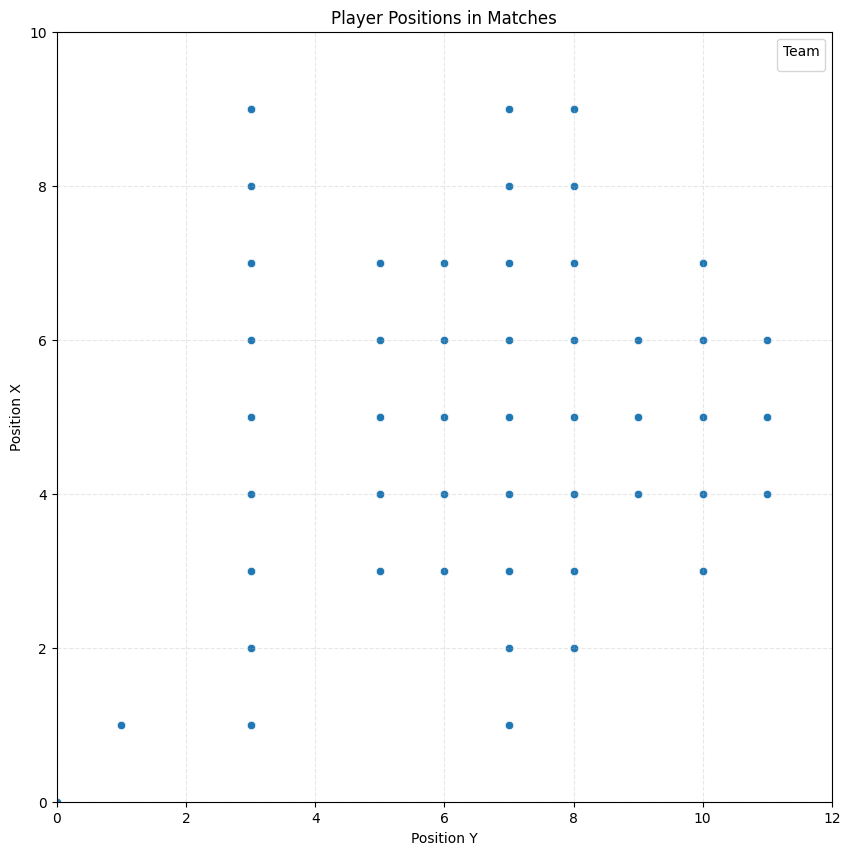

In [40]:
# scatter plot of position x and y
plt.figure(figsize=(10, 10))
sns.scatterplot(data=player_match_df, x='position_y', y='position_x')
plt.title('Player Positions in Matches')
plt.xlabel('Position Y')
plt.ylabel('Position X')
plt.xlim(0, 12)
plt.ylim(0, 10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(title='Team', loc='upper right')
plt.show()

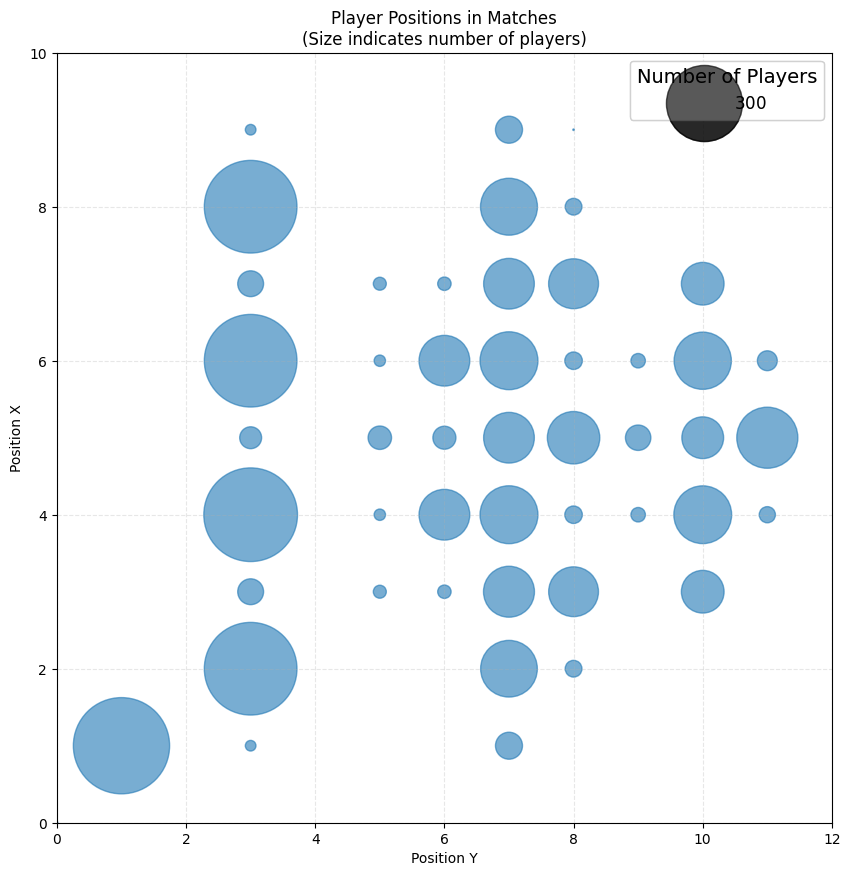

In [41]:
# Count number of players in each position combination
position_counts = player_match_df.groupby(['position_x', 'position_y']).size().reset_index(name='count')

plt.figure(figsize=(10, 10))
# Use size parameter to scale the points based on count
scatter = plt.scatter(position_counts['position_y'], 
                     position_counts['position_x'], 
                     s=position_counts['count']/10, # multiply by 2 to make points more visible
                     alpha=0.6)

plt.title('Player Positions in Matches\n(Size indicates number of players)')
plt.xlabel('Position Y')
plt.ylabel('Position X')
plt.xlim(0, 12)
plt.ylim(0, 10)
plt.grid(True, alpha=0.3, linestyle='--')

# Add a legend showing the scale
legend1 = plt.legend(*scatter.legend_elements(prop="sizes", alpha=0.6, 
                                            num=1, 
                                            func=lambda s: s/10), # divide by 10 to show actual counts
                    loc="upper right", 
                    title="Number of Players",
                    fontsize=12,
                    title_fontsize=14)
plt.gca().add_artist(legend1)

plt.show()

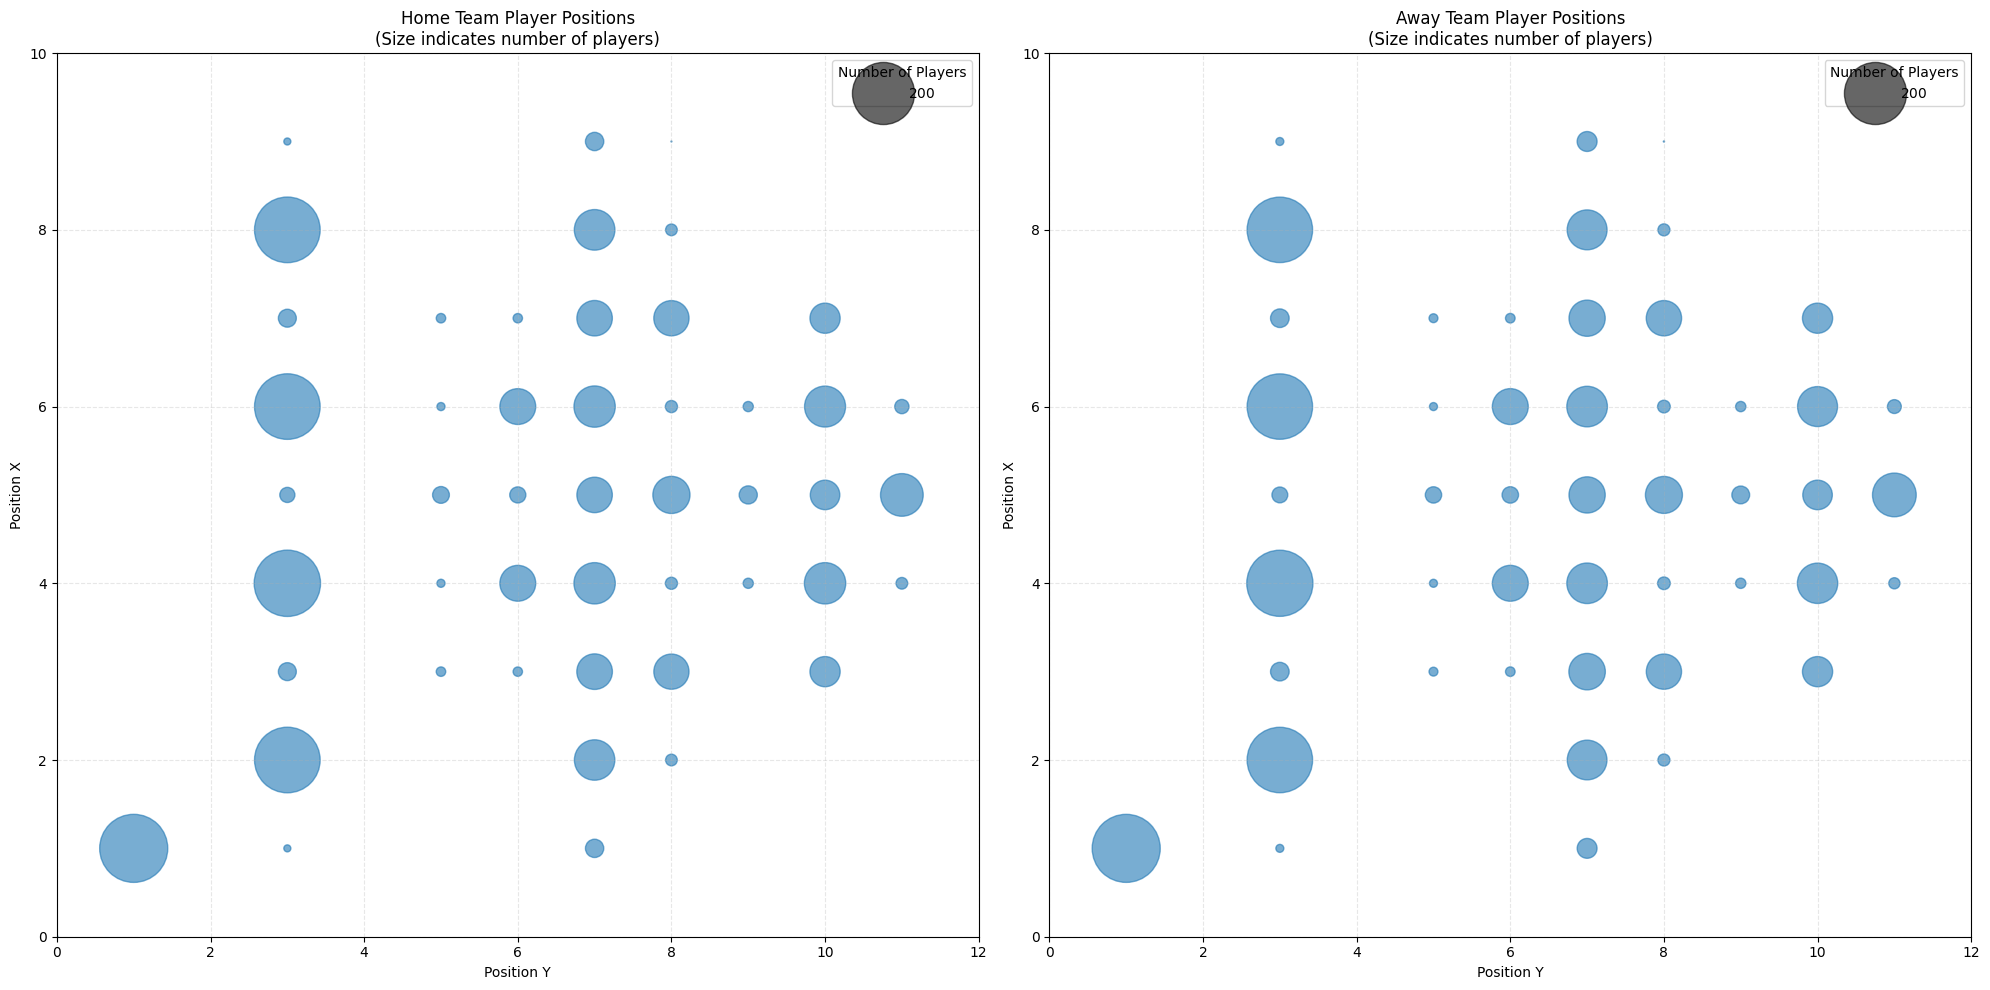

In [42]:
# Split data by team
home_positions = position_counts = player_match_df[player_match_df['team'] == 'home'].groupby(['position_x', 'position_y']).size().reset_index(name='count')
away_positions = position_counts = player_match_df[player_match_df['team'] == 'away'].groupby(['position_x', 'position_y']).size().reset_index(name='count')

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot home team positions
scatter1 = ax1.scatter(home_positions['position_y'], 
                      home_positions['position_x'], 
                      s=home_positions['count']/10,
                      alpha=0.6)
ax1.set_title('Home Team Player Positions\n(Size indicates number of players)')
ax1.set_xlabel('Position Y')
ax1.set_ylabel('Position X')
ax1.set_xlim(0, 12)
ax1.set_ylim(0, 10)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot away team positions
scatter2 = ax2.scatter(away_positions['position_y'], 
                      away_positions['position_x'], 
                      s=away_positions['count']/10,
                      alpha=0.6)
ax2.set_title('Away Team Player Positions\n(Size indicates number of players)')
ax2.set_xlabel('Position Y')
ax2.set_ylabel('Position X')
ax2.set_xlim(0, 12)
ax2.set_ylim(0, 10)
ax2.grid(True, alpha=0.3, linestyle='--')

# Add legends
legend1 = ax1.legend(*scatter1.legend_elements(prop="sizes", alpha=0.6, 
                                             num=1, 
                                             func=lambda s: s/10),
                    loc="upper right", 
                    title="Number of Players")

legend2 = ax2.legend(*scatter2.legend_elements(prop="sizes", alpha=0.6, 
                                             num=1, 
                                             func=lambda s: s/10),
                    loc="upper right", 
                    title="Number of Players")

plt.tight_layout()
plt.show()

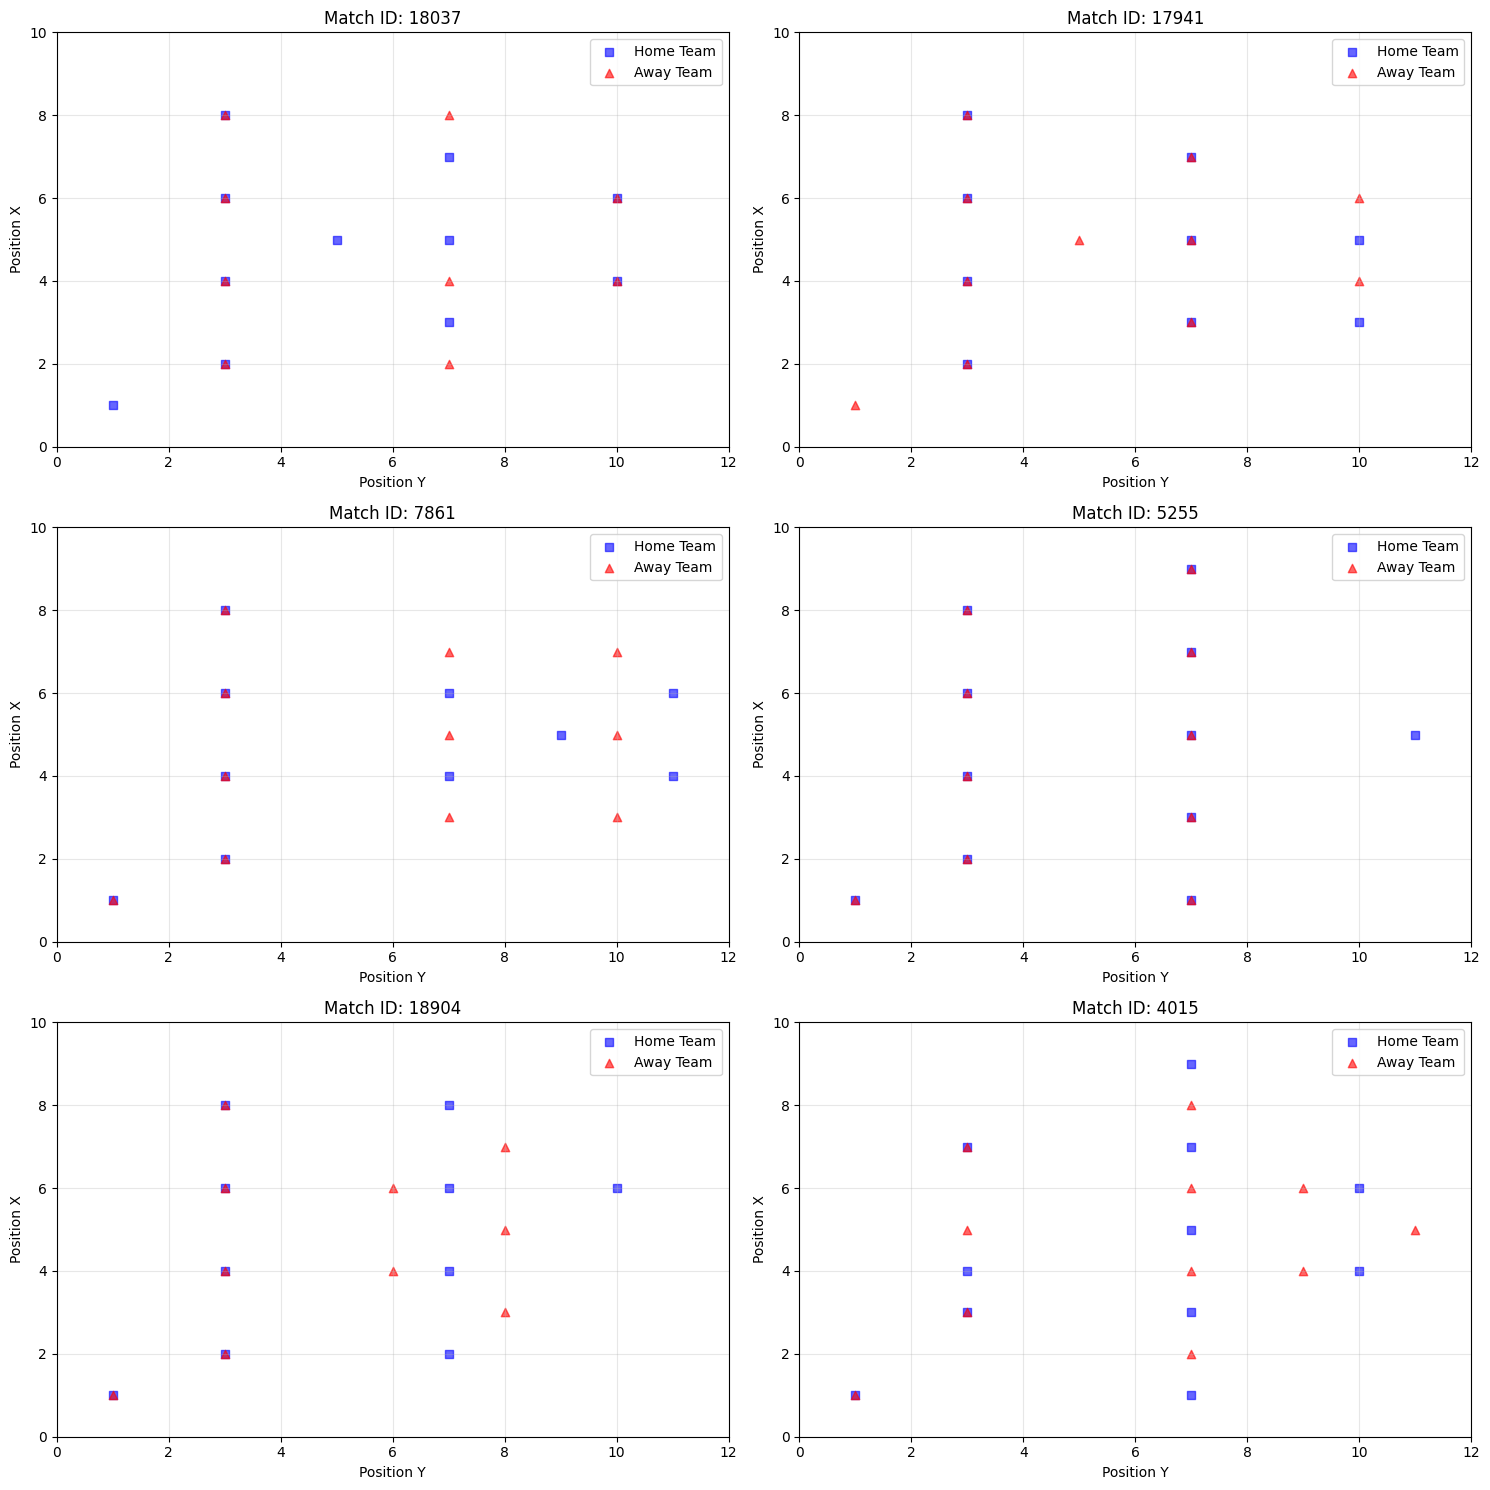

In [43]:
# Match player positions in graph 

player_match_df_copy = player_match_df.copy()

# Get a sample of matches to plot (e.g., first 4 matches)
sample_matches = player_match_df_copy.groupby('match_id')
# Get unique position combinations for each match
position_summary = player_match_df_copy.groupby('match_id').agg({
    'position_x': lambda x: tuple(sorted(x)),
    'position_y': lambda x: tuple(sorted(x))
}).reset_index()

# Find matches with different position patterns
different_position_matches = position_summary.drop_duplicates(subset=['position_x', 'position_y'])

# Get first 4 matches with different position patterns
sample_match_ids = different_position_matches['match_id'].sample(6)

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.ravel()

# Plot each match's player positions
for idx, match_id in enumerate(sample_match_ids):
    match_positions = player_match_df[player_match_df['match_id'] == match_id]
    
    # Create scatter plot for this match
    axes[idx].scatter(match_positions[match_positions['team'] == 'home']['position_y'],
                     match_positions[match_positions['team'] == 'home']['position_x'],
                     marker='s', c='blue', label='Home Team', alpha=0.6)
    axes[idx].scatter(match_positions[match_positions['team'] == 'away']['position_y'],
                     match_positions[match_positions['team'] == 'away']['position_x'],
                     marker='^', c='red', label='Away Team', alpha=0.6)
    
    # Customize the subplot
    axes[idx].set_title(f'Match ID: {match_id}')
    axes[idx].set_xlabel('Position Y')
    axes[idx].set_ylabel('Position X')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim(0, 12)
    axes[idx].set_ylim(0, 10)
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [44]:
# Convert xy to position name
def get_position_name(x, y):
    # Define regions for positions
    # Goalkeeper
    if x < 2 and y < 2:
        return "GK"  # Goalkeeper

    # Defense line
    if 2 <= y < 4:
        if x < 4:  # Right side
            return "RB"  # Right Back
        elif 4 <= x <= 6:  # Center
            return "CB"  # Center Back
        else:  # Left side
            return "LB"  # Left Back

    # Midfield line
    if 4 <= y < 9:
        if x < 4:  # Right side
            return "RM"  # Right Midfielder
        elif 4 <= x <= 6:  # Center
            return "CM"  # Central Midfielder
        else:  # Left side
            return "LM"  # Left Midfielder

    # Forward line
    if y >= 9:
        if x < 4:  # Right side
            return "RW"  # Right Wing
        elif 4 <= x <= 6:  # Center
            return "CF"  # Center Forward
        else:  # Left side
            return "LW"  # Left Wing

    # Default fallback
    return "Unknown"

player_match_df['position_name'] = player_match_df[['position_x', 'position_y']].apply(
    lambda row: get_position_name(row['position_x'], row['position_y']), axis=1)
# Check the unique position names
player_match_df['position_name'].unique()

array(['GK', 'RB', 'CB', 'LB', 'CM', 'RM', 'LM', 'CF', 'RW', 'LW'],
      dtype=object)

In [45]:
player_match_df['position_name_code'] = player_match_df['position_name'].astype('category').cat.codes
player_match_df['position_name_code'].unique()

array([3, 7, 0, 4, 2, 8, 5, 1, 9, 6], dtype=int8)

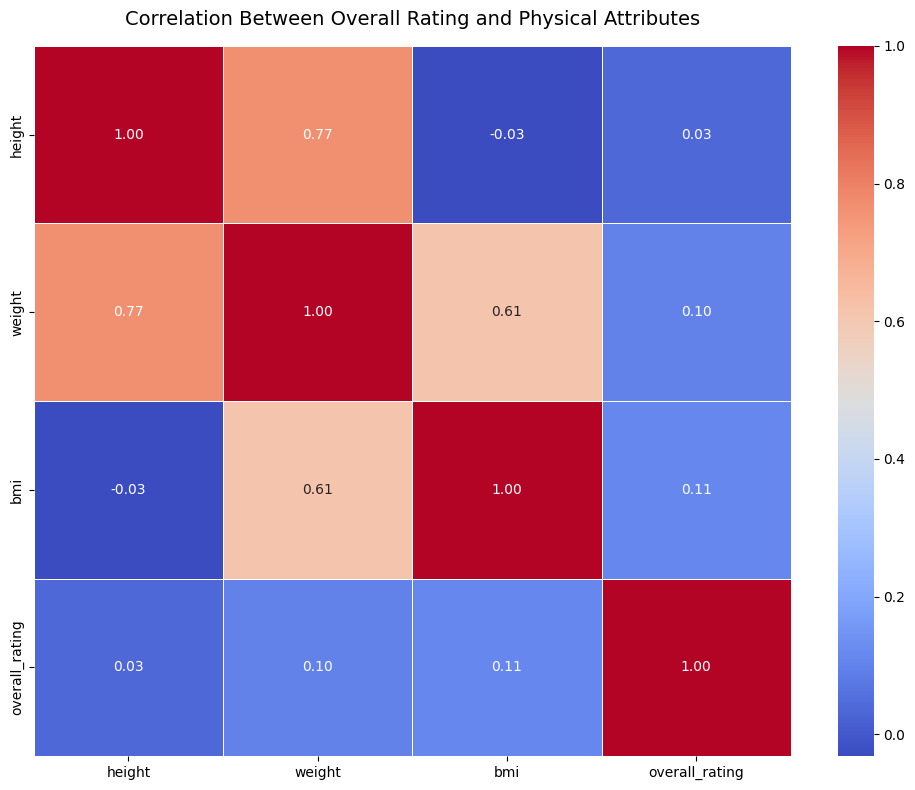

In [46]:
# Plot correlation matrix of player positions and physical attributes
position_physical_df = player_match_df[['height', 'weight', 'bmi', 'overall_rating']]

# Create correlation matrix
corr_matrix = position_physical_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Between Overall Rating and Physical Attributes', fontsize=14, pad=15)
plt.tight_layout()
plt.show()


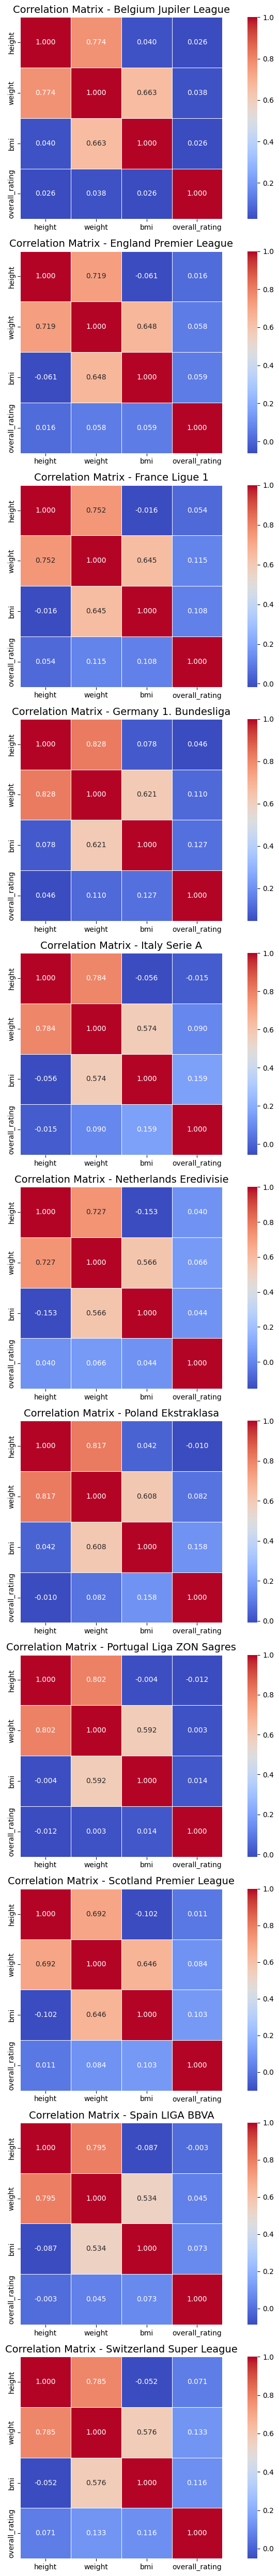

In [47]:
# Plot correlation matrices for specific leagues
# Select major leagues for analysis
major_leagues = player_match_df['league_name'].unique()

# Create a figure with subplots for each league
fig, axes = plt.subplots(len(major_leagues), 1, figsize=(10, 50))

# For each league, create a correlation matrix and plot it
for i, league in enumerate(major_leagues):
    # Filter data for this league
    league_df = player_match_df[player_match_df['league_name'] == league]
    
    # If we have data for this league, create correlation matrix
    if not league_df.empty:
        # Extract the relevant columns
        league_data = league_df[['height', 'weight', 'bmi', 'overall_rating']]
        
        # Create correlation matrix
        corr = league_data.corr()
        
        # Plot heatmap
        sns.heatmap(corr, annot=True, fmt='.3f', cmap='coolwarm', 
                   linewidths=0.5, ax=axes[i], square=True)
        
        # Add title
        axes[i].set_title(f'Correlation Matrix - {league}', fontsize=14)
    else:
        # If no data for this league, display a message
        axes[i].text(0.5, 0.5, f'No data available for {league}', 
                    horizontalalignment='center', fontsize=14)
        axes[i].axis('off')

plt.tight_layout()
plt.show()

<Figure size 1000x1500 with 0 Axes>

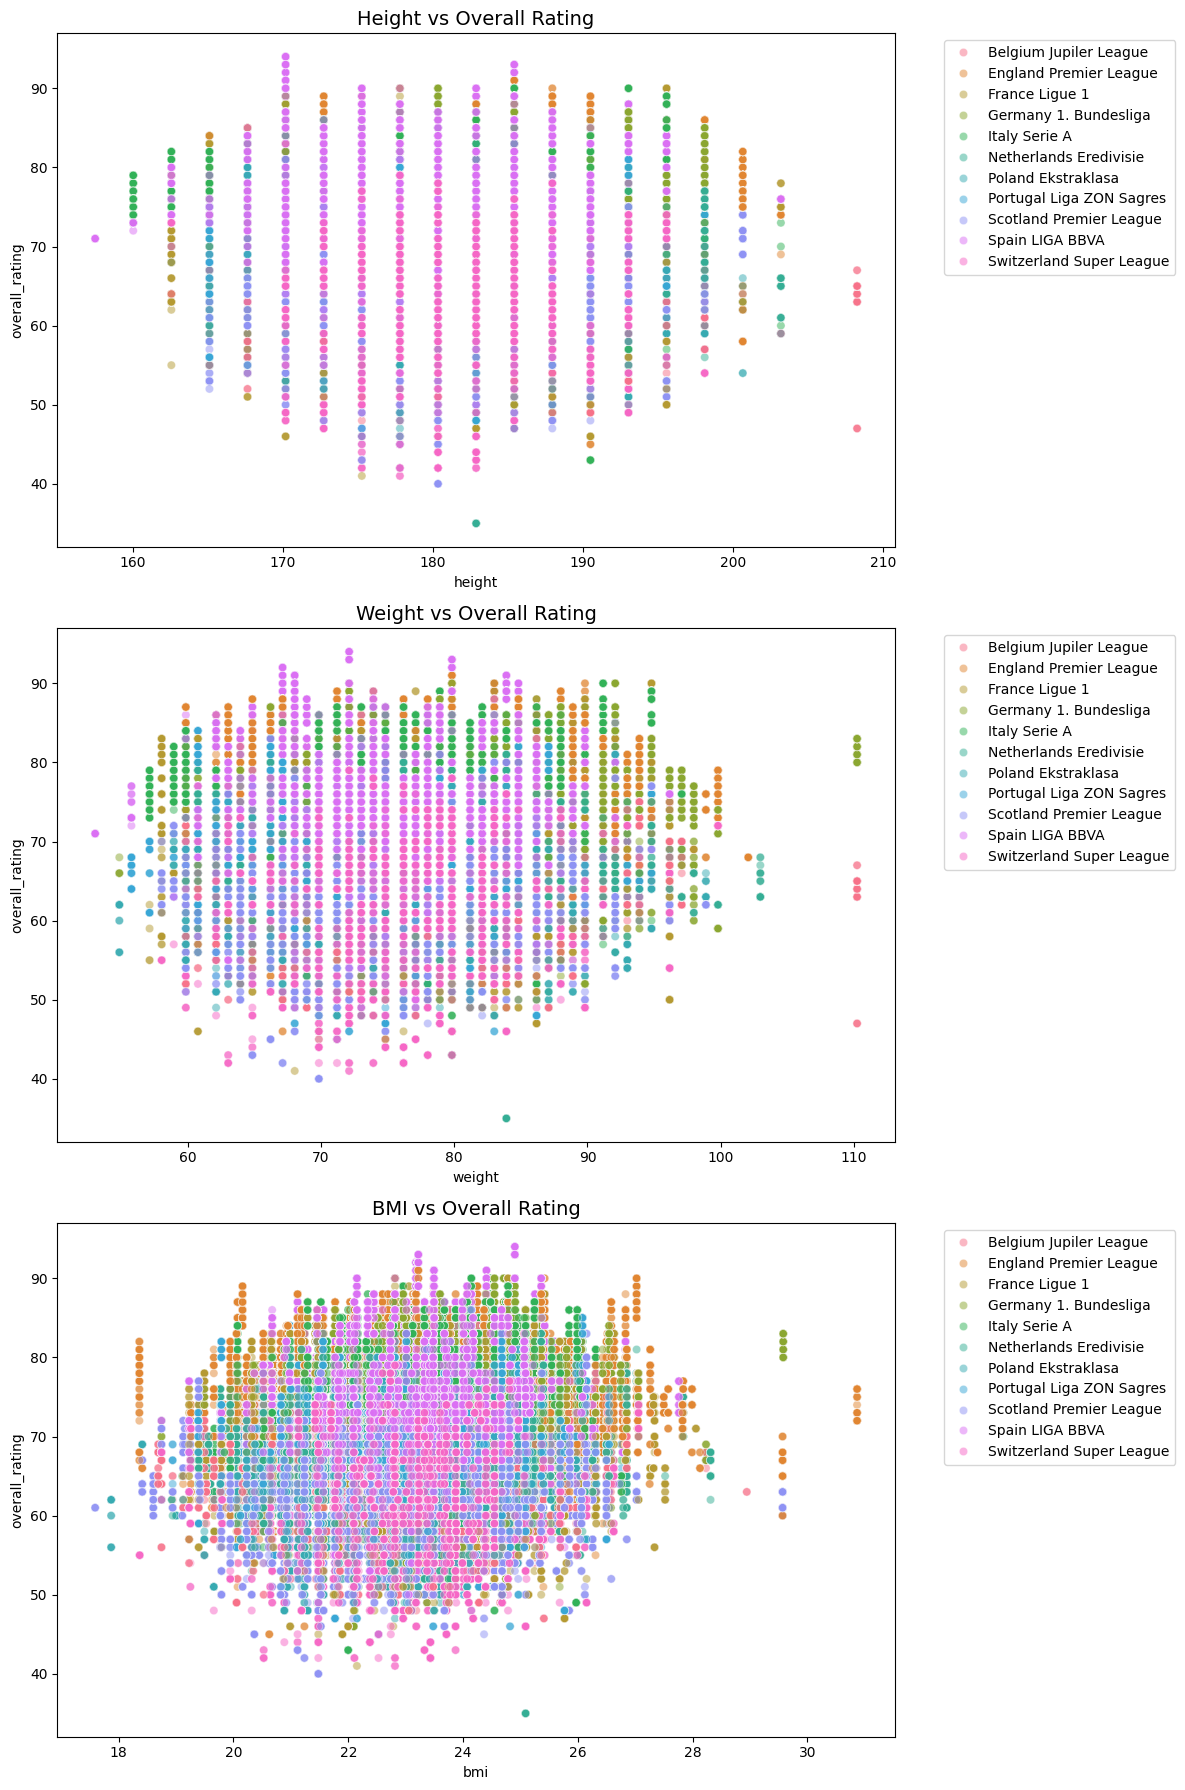

In [48]:
# Create the plot with color grouping by league
plt.figure(figsize=(10, 15))

# Create three subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plot height vs overall rating
sns.scatterplot(data=player_match_df, 
                x='height', 
                y='overall_rating', 
                hue='league_name',
                alpha=0.5,
                ax=axes[0])
axes[0].set_title('Height vs Overall Rating', fontsize=14)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot weight vs overall rating
sns.scatterplot(data=player_match_df, 
                x='weight', 
                y='overall_rating', 
                hue='league_name',
                alpha=0.5,
                ax=axes[1])
axes[1].set_title('Weight vs Overall Rating', fontsize=14)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot BMI vs overall rating
sns.scatterplot(data=player_match_df, 
                x='bmi', 
                y='overall_rating', 
                hue='league_name',
                alpha=0.5,
                ax=axes[2])
axes[2].set_title('BMI vs Overall Rating', fontsize=14)
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

<Figure size 1500x1000 with 0 Axes>

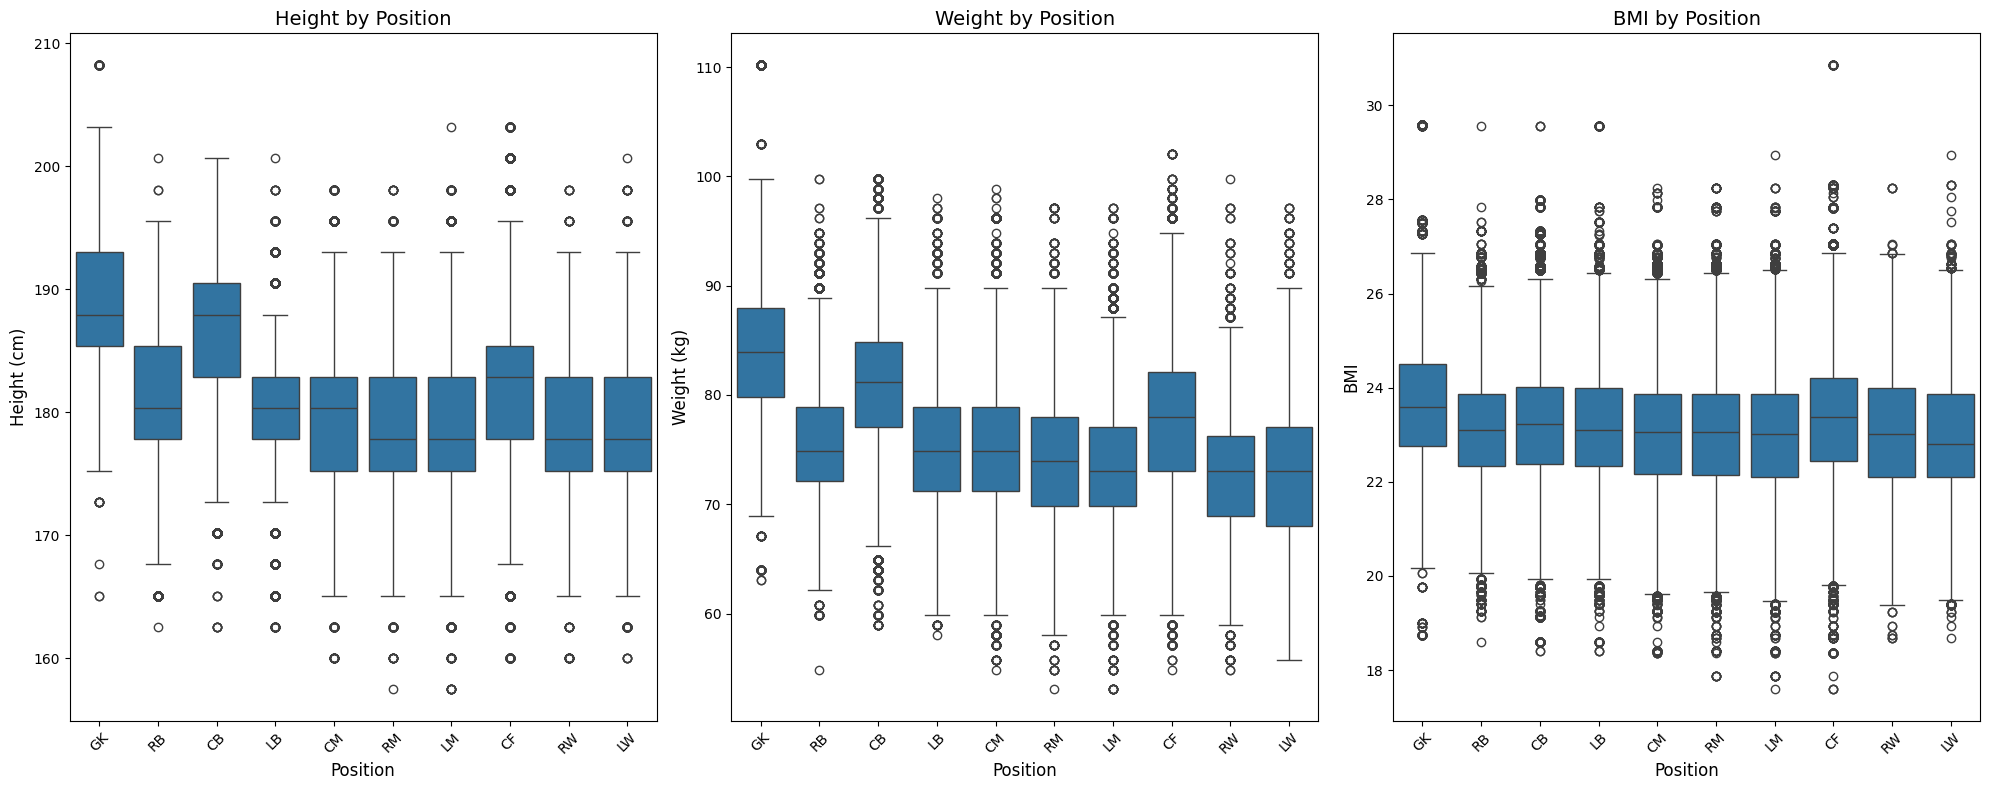

In [49]:
# Create more detailed analysis with boxplots
plt.figure(figsize=(15, 10))

# Create a subplot for each physical attribute
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Map position codes to names for better readability
position_map = {code: name for code, name in zip(
    player_match_df['position_name_code'].unique(),
    player_match_df['position_name'].unique()
)}

# Boxplot for height by position
sns.boxplot(x='position_name', y='height', data=player_match_df, ax=axes[0])
axes[0].set_title('Height by Position', fontsize=14)
axes[0].set_xlabel('Position', fontsize=12)
axes[0].set_ylabel('Height (cm)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Boxplot for weight by position
sns.boxplot(x='position_name', y='weight', data=player_match_df, ax=axes[1])
axes[1].set_title('Weight by Position', fontsize=14)
axes[1].set_xlabel('Position', fontsize=12)
axes[1].set_ylabel('Weight (kg)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# Boxplot for BMI by position
sns.boxplot(x='position_name', y='bmi', data=player_match_df, ax=axes[2])
axes[2].set_title('BMI by Position', fontsize=14)
axes[2].set_xlabel('Position', fontsize=12)
axes[2].set_ylabel('BMI', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

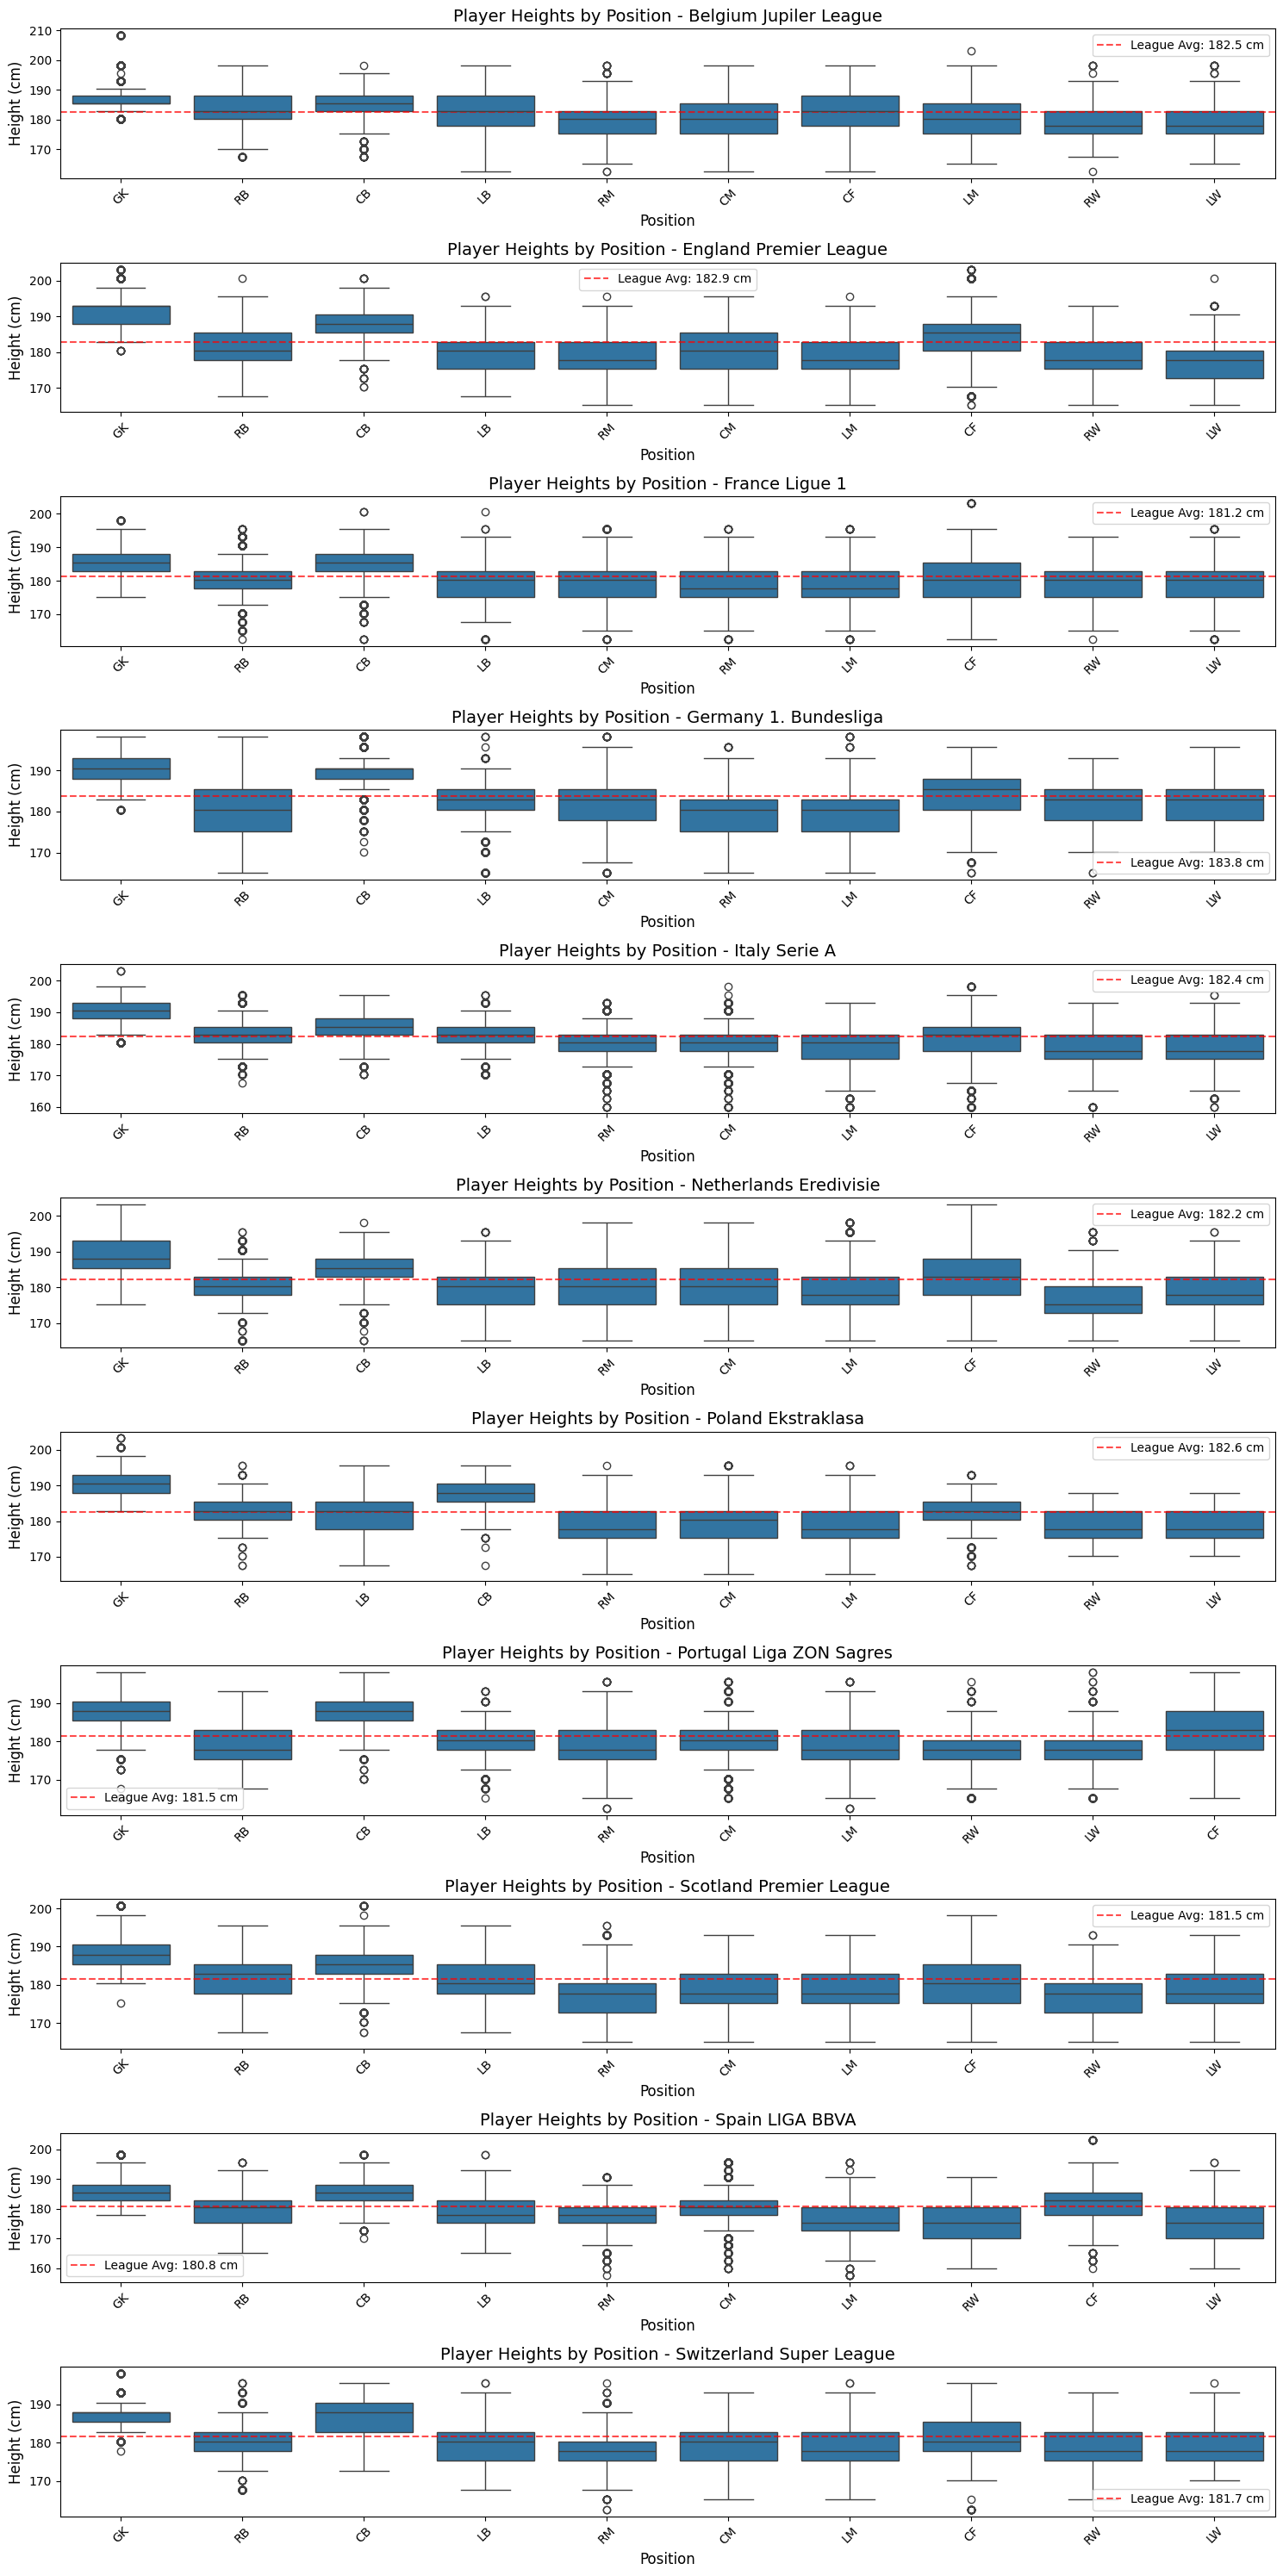

In [50]:
# Create boxplots comparing player heights across positions for each league
fig, axes = plt.subplots(len(major_leagues), 1, figsize=(15, 30))

for i, league in enumerate(major_leagues):
    # Filter data for this league
    league_df = player_match_df[player_match_df['league_name'] == league]

    if not league_df.empty:
        # Create boxplot
        sns.boxplot(x='position_name', y='height', data=league_df, ax=axes[i])

        # Add title and labels
        axes[i].set_title(
            f'Player Heights by Position - {league}', fontsize=14)
        axes[i].set_xlabel('Position', fontsize=12)
        axes[i].set_ylabel('Height (cm)', fontsize=12)
        axes[i].tick_params(axis='x', rotation=45)

        # Add league average line
        avg_height = league_df['height'].mean()
        axes[i].axhline(avg_height, color='red', linestyle='--',
                        alpha=0.7, label=f'League Avg: {avg_height:.1f} cm')
        axes[i].legend()
    else:
        axes[i].text(0.5, 0.5, f'No data available for {league}',
                     horizontalalignment='center', fontsize=14)
        axes[i].axis('off')

plt.tight_layout()
plt.show()


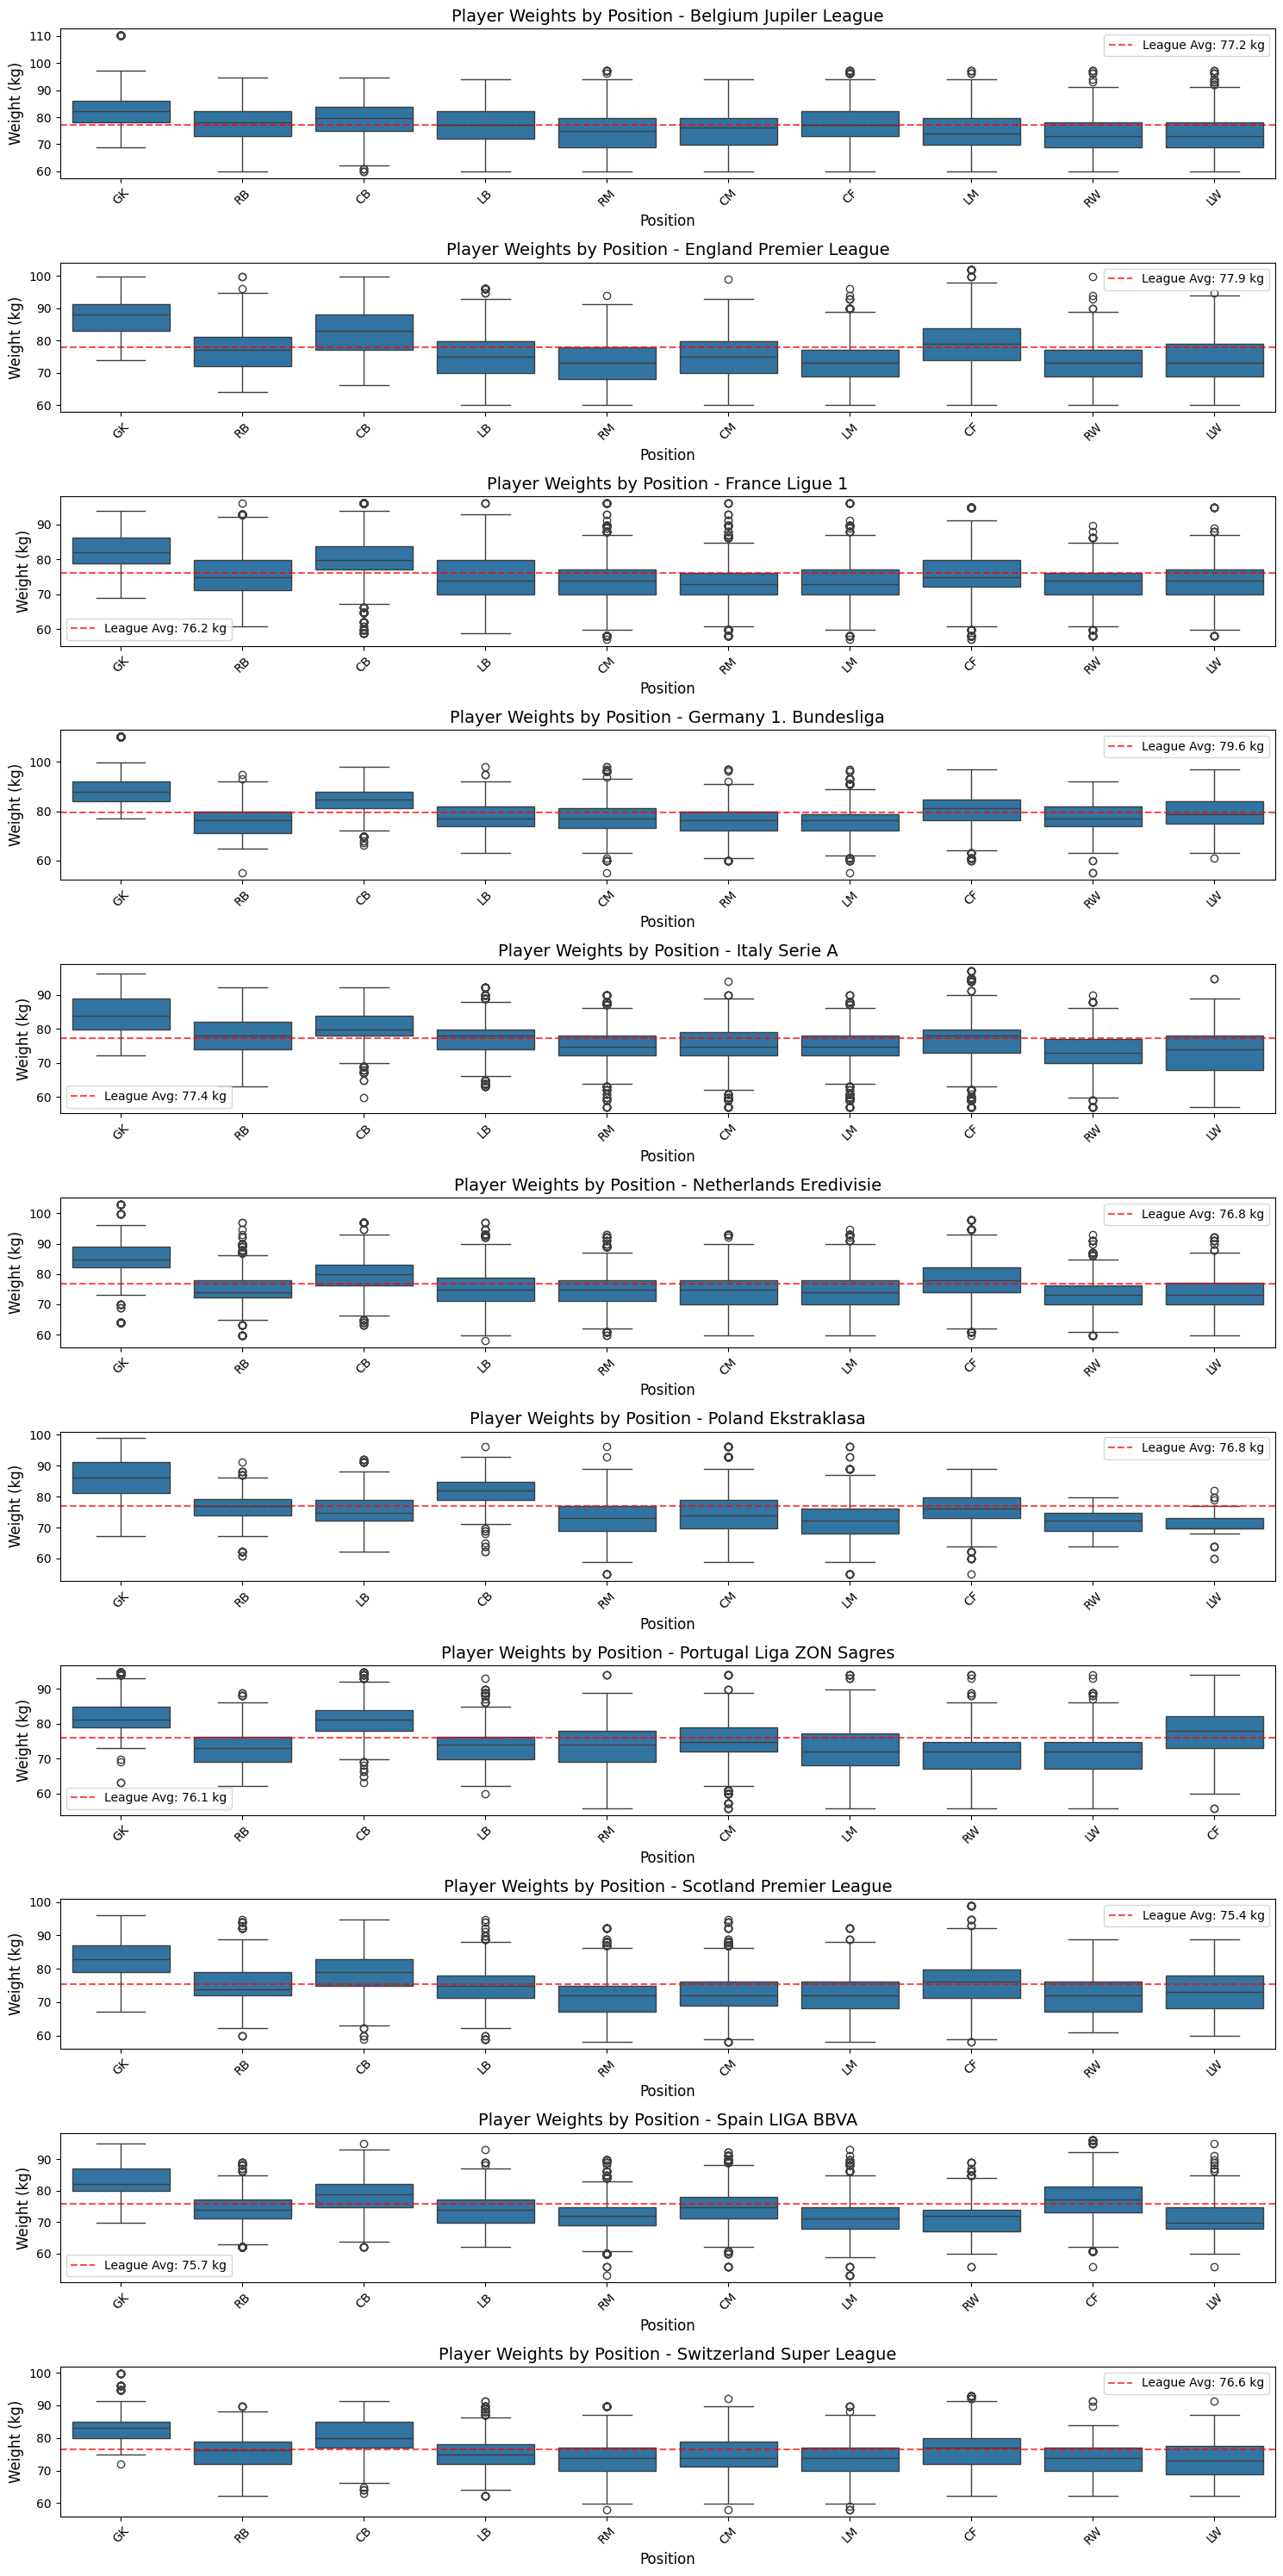

In [51]:
# Create boxplots comparing player weights across positions for each league
fig, axes = plt.subplots(len(major_leagues), 1, figsize=(15, 30))

for i, league in enumerate(major_leagues):
    # Filter data for this league
    league_df = player_match_df[player_match_df['league_name'] == league]

    if not league_df.empty:
        # Create boxplot
        sns.boxplot(x='position_name', y='weight', data=league_df, ax=axes[i])

        # Add title and labels
        axes[i].set_title(
            f'Player Weights by Position - {league}', fontsize=14)
        axes[i].set_xlabel('Position', fontsize=12)
        axes[i].set_ylabel('Weight (kg)', fontsize=12)
        axes[i].tick_params(axis='x', rotation=45)

        # Add league average line
        avg_weight = league_df['weight'].mean()
        axes[i].axhline(avg_weight, color='red', linestyle='--',
                        alpha=0.7, label=f'League Avg: {avg_weight:.1f} kg')
        axes[i].legend()
    else:
        axes[i].text(0.5, 0.5, f'No data available for {league}',
                     horizontalalignment='center', fontsize=14)
        axes[i].axis('off')
plt.tight_layout()
plt.show()


# Q3

Analyze the defensive vs. offensive balance: For each league, examine the relationship between goals scored and goals conceded, identifying teams that succeeded with defensive-focused strategies versus offensive-focused approaches. 

In [52]:
df_match_player_denorm = db.execute_query_df("""
    SELECT m.season, m.home_team_goal, m.away_team_goal, l.name as league_name,
           t_home.team_long_name as home_team_name, t_away.team_long_name as away_team_name
    FROM Match m
    INNER JOIN League l ON m.league_id = l.id
    INNER JOIN Team t_home ON m.home_team_api_id = t_home.team_api_id
    INNER JOIN Team t_away ON m.away_team_api_id = t_away.team_api_id
""")
df_match_player_denorm

season  home_team_goal  away_team_goal               league_name  \
0      2008/2009               1               1    Belgium Jupiler League   
1      2008/2009               0               0    Belgium Jupiler League   
2      2008/2009               0               3    Belgium Jupiler League   
3      2008/2009               5               0    Belgium Jupiler League   
4      2008/2009               1               3    Belgium Jupiler League   
...          ...             ...             ...                       ...   
25974  2015/2016               1               0  Switzerland Super League   
25975  2015/2016               1               2  Switzerland Super League   
25976  2015/2016               2               0  Switzerland Super League   
25977  2015/2016               0               0  Switzerland Super League   
25978  2015/2016               4               3  Switzerland Super League   

                home_team_name     away_team_name  
0                     KRC Genk       Beerschot AC  
1             SV Zulte-Waregem   Sporting Lokeren  
2            KSV Cercle Brugge     RSC Anderlecht  
3                     KAA Gent          RAEC Mons  
4                FCV Dender EH  Standard de Liège  
...                        ...                ...  
25974            FC St. Gallen            FC Thun  
25975                 FC Vaduz          FC Luzern  
25976  Grasshopper Club Zürich            FC Sion  
25977                   Lugano          FC Zürich  
25978           BSC Young Boys           FC Basel  

[25979 rows x 6 columns]

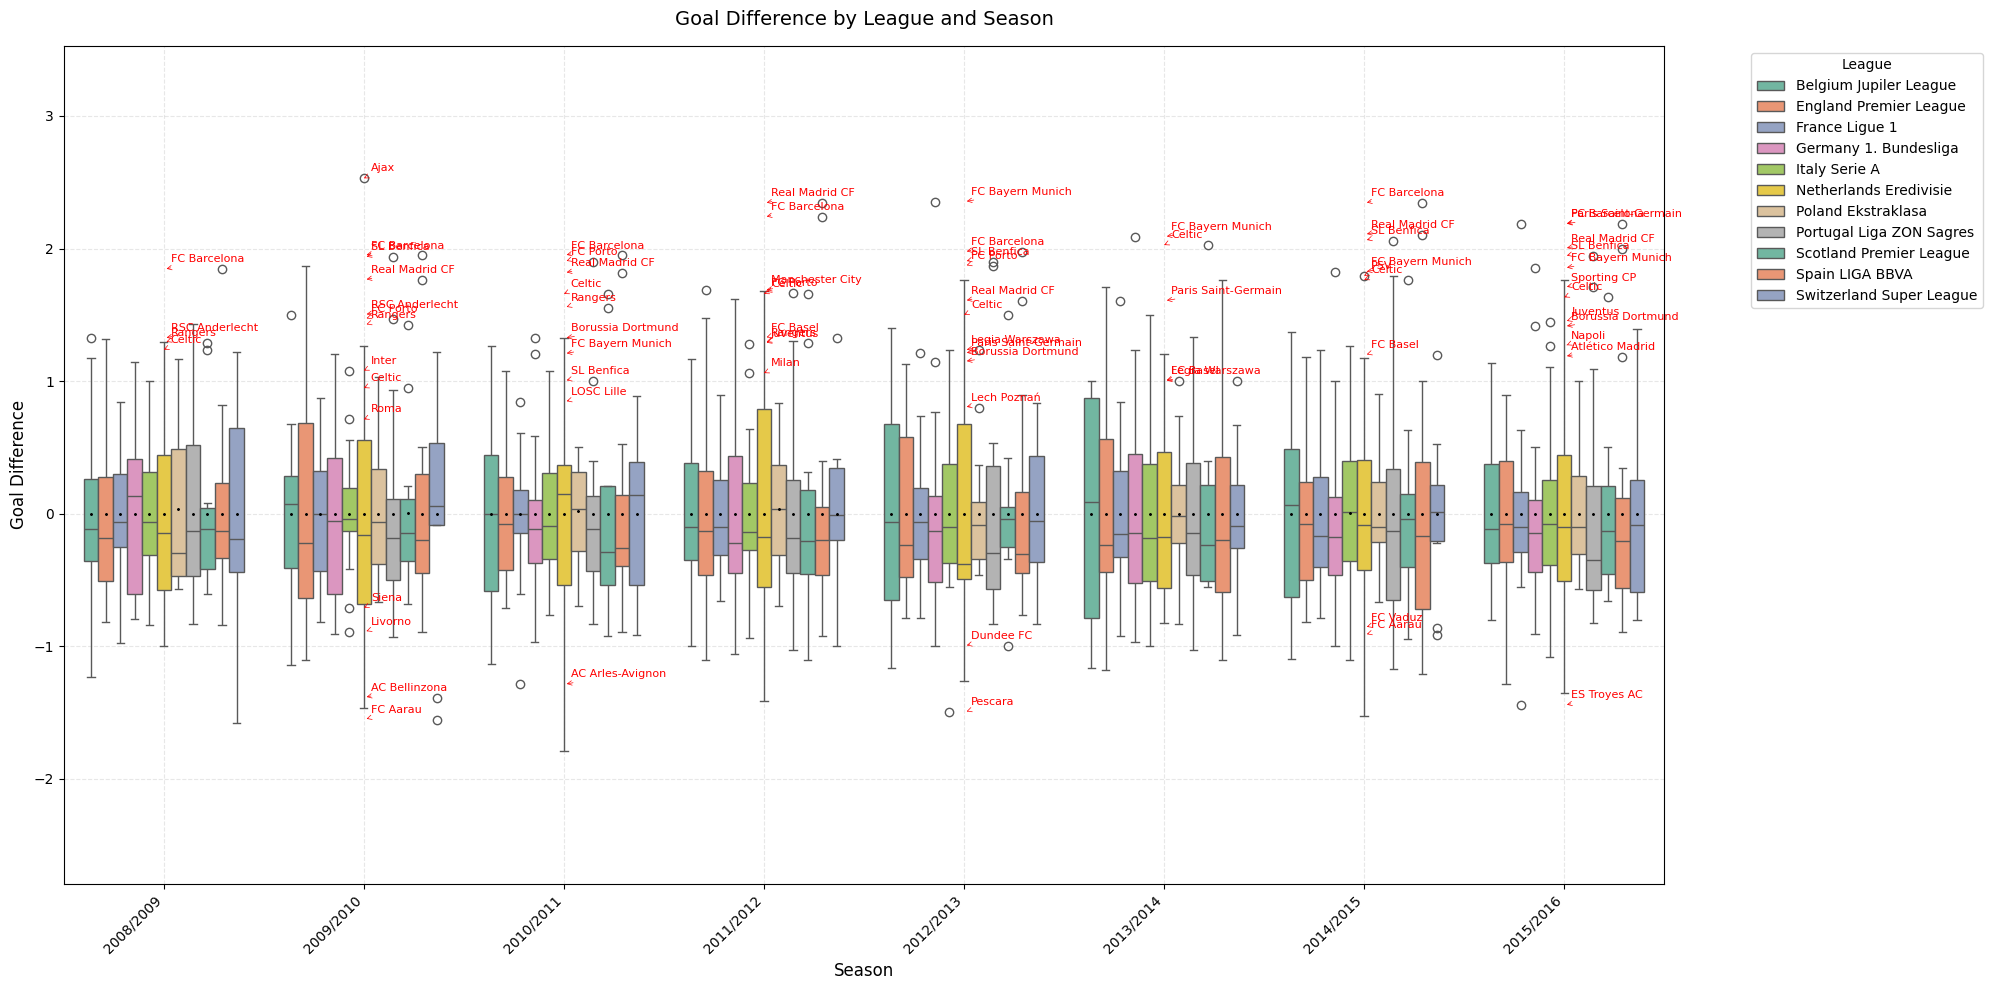

In [53]:
# Calculate offensive and defensive rating by team per season and league
# First, calculate home stats
home_stats = df_match_player_denorm.groupby(['season', 'league_name', 'home_team_name']).agg(
    home_offensive_rating=('home_team_goal', 'mean'),
    home_defensive_rating=('away_team_goal', 'mean')
).reset_index()

# Then calculate away stats
away_stats = df_match_player_denorm.groupby(['season', 'league_name', 'away_team_name']).agg(
    away_offensive_rating=('away_team_goal', 'mean'),
    away_defensive_rating=('home_team_goal', 'mean')
).reset_index()

# Rename columns to merge
away_stats = away_stats.rename(columns={'away_team_name': 'home_team_name'})

# Merge the two dataframes
df_team_stats = pd.merge(home_stats, away_stats,
                         on=['season', 'league_name', 'home_team_name'],
                         how='outer')

# Calculate overall offensive and defensive ratings
df_team_stats['offensive_rating'] = (df_team_stats['home_offensive_rating'].fillna(0) +
                                     df_team_stats['away_offensive_rating'].fillna(0)) / 2
df_team_stats['defensive_rating'] = (df_team_stats['home_defensive_rating'].fillna(0) +
                                     df_team_stats['away_defensive_rating'].fillna(0)) / 2

# Keep only the columns we need
df_team_stats = df_team_stats[['season', 'league_name', 'home_team_name',
                              'offensive_rating', 'defensive_rating']]

df_team_stats['goal_difference'] = df_team_stats['offensive_rating'] - \
    df_team_stats['defensive_rating']
df_team_stats

# Box plot for goal difference by league per season
plt.figure(figsize=(20, 10))
sns.boxplot(data=df_team_stats, x='season', y='goal_difference', hue='league_name', palette='Set2', showmeans=True,
            meanprops={'marker': 'D', 'markerfacecolor': 'white', 'markeredgecolor': 'black', 'markersize': '1'})
plt.title('Goal Difference by League and Season', fontsize=14, pad=15)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Goal Difference', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='League', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, linestyle='--')
plt.ylim(df_team_stats['goal_difference'].min() - 1,
         df_team_stats['goal_difference'].max() + 1)
plt.tight_layout()

# Highlight the outliers
# Identify outliers in each season/league combination
for season in df_team_stats['season'].unique():
    for league in df_team_stats['league_name'].unique():
        season_league_data = df_team_stats[(df_team_stats['season'] == season) &
                                           (df_team_stats['league_name'] == league)]
        if len(season_league_data) > 0:
            # Calculate Q1, Q3 and IQR
            Q1 = season_league_data['goal_difference'].quantile(0.25)
            Q3 = season_league_data['goal_difference'].quantile(0.75)
            IQR = Q3 - Q1

            # Define bounds for outliers
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Find outliers
            outliers = season_league_data[(season_league_data['goal_difference'] < lower_bound) |
                                          (season_league_data['goal_difference'] > upper_bound)]

            # Annotate outliers
            for idx, row in outliers.iterrows():
                plt.annotate(row['home_team_name'],
                             xy=(row['season'], row['goal_difference']),
                             xytext=(5, 5),
                             textcoords='offset points',
                             fontsize=8,
                             color='red',
                             arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

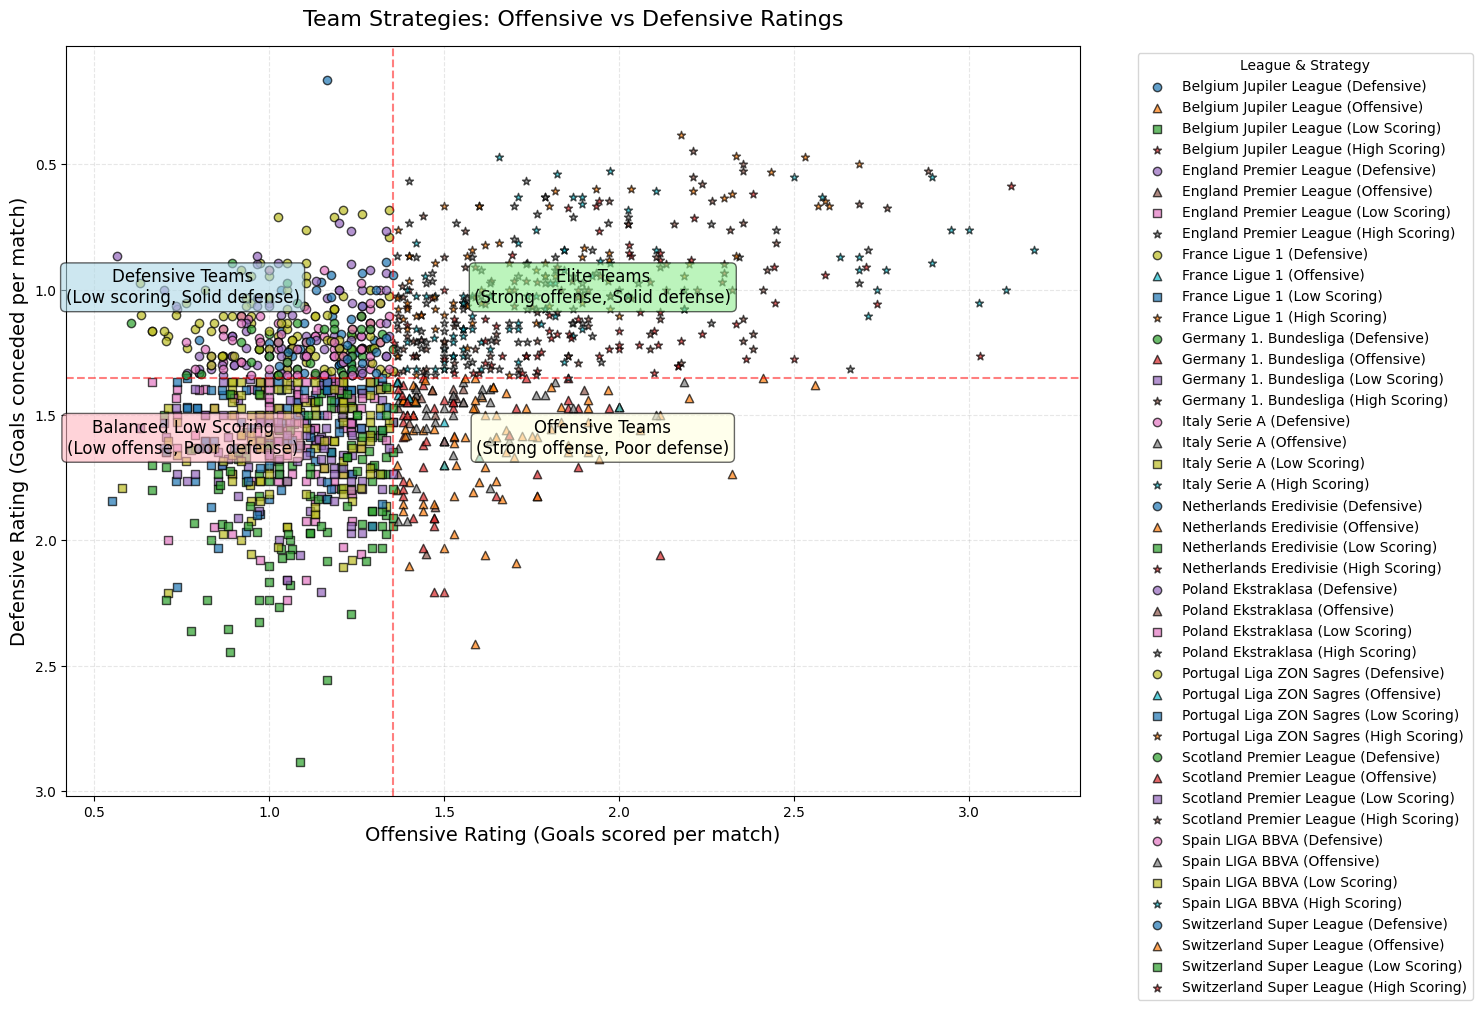

In [54]:
# Plot offensive and defensive ratings per league with clearer categorization
plt.figure(figsize=(15, 10))

# Calculate the average offensive and defensive ratings to use as dividing lines
avg_offensive = df_team_stats['offensive_rating'].mean()
avg_defensive = df_team_stats['defensive_rating'].mean()

# Create a scatter plot for each league with better categorization
for league in df_team_stats['league_name'].unique():
    league_data = df_team_stats[df_team_stats['league_name'] == league]

    # Classify teams by their strategy
    defensive_teams = league_data[(league_data['offensive_rating'] < avg_offensive) &
                                  (league_data['defensive_rating'] < avg_defensive)]
    offensive_teams = league_data[(league_data['offensive_rating'] > avg_offensive) &
                                  (league_data['defensive_rating'] > avg_defensive)]
    balanced_defensive = league_data[(league_data['offensive_rating'] < avg_offensive) &
                                     (league_data['defensive_rating'] > avg_defensive)]
    balanced_offensive = league_data[(league_data['offensive_rating'] > avg_offensive) &
                                     (league_data['defensive_rating'] < avg_defensive)]

    # Plot with different markers for different strategies
    plt.scatter(defensive_teams['offensive_rating'], defensive_teams['defensive_rating'],
                alpha=0.7, edgecolors='k', marker='o', label=f'{league} (Defensive)' if len(defensive_teams) > 0 else None)
    plt.scatter(offensive_teams['offensive_rating'], offensive_teams['defensive_rating'],
                alpha=0.7, edgecolors='k', marker='^', label=f'{league} (Offensive)' if len(offensive_teams) > 0 else None)
    plt.scatter(balanced_defensive['offensive_rating'], balanced_defensive['defensive_rating'],
                alpha=0.7, edgecolors='k', marker='s', label=f'{league} (Low Scoring)' if len(balanced_defensive) > 0 else None)
    plt.scatter(balanced_offensive['offensive_rating'], balanced_offensive['defensive_rating'],
                alpha=0.7, edgecolors='k', marker='*', label=f'{league} (High Scoring)' if len(balanced_offensive) > 0 else None)

# Add reference lines for the average values
plt.axvline(x=avg_offensive, color='red', linestyle='--', alpha=0.5)
plt.axhline(y=avg_defensive, color='red', linestyle='--', alpha=0.5)

# Add annotations to highlight the quadrants
plt.annotate('Defensive Teams\n(Low scoring, Solid defense)', xy=(avg_offensive-0.6, avg_defensive-0.3),
             fontsize=12, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", alpha=0.6))
plt.annotate('Balanced Low Scoring\n(Low offense, Poor defense)', xy=(avg_offensive-0.6, avg_defensive+0.3),
             fontsize=12, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightpink", alpha=0.6))
plt.annotate('Elite Teams\n(Strong offense, Solid defense)', xy=(avg_offensive+0.6, avg_defensive-0.3),
             fontsize=12, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", alpha=0.6))
plt.annotate('Offensive Teams\n(Strong offense, Poor defense)', xy=(avg_offensive+0.6, avg_defensive+0.3),
             fontsize=12, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", alpha=0.6))

# Customize the plot
plt.title('Team Strategies: Offensive vs Defensive Ratings', fontsize=16, pad=15)
plt.xlabel('Offensive Rating (Goals scored per match)', fontsize=14)
plt.ylabel('Defensive Rating (Goals conceded per match)', fontsize=14)

# Create a custom legend to avoid duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='League & Strategy',
           bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# Invert y-axis so that better defensive ratings (lower values) are higher on the chart
plt.gca().invert_yaxis()

# Adjust layout to prevent label cutoff
plt.tight_layout()

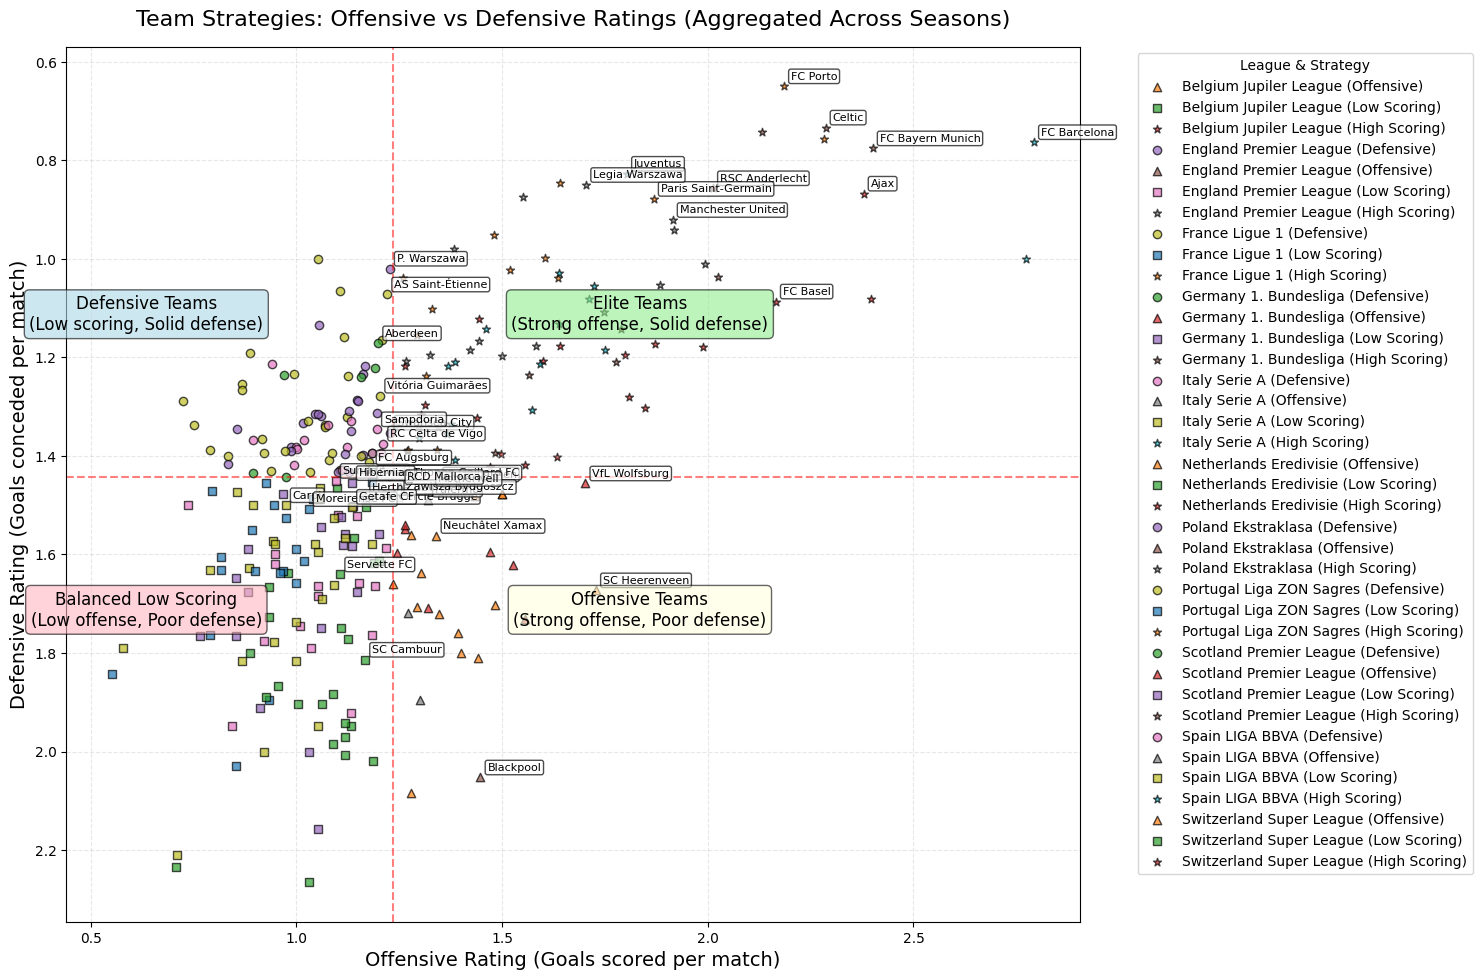

In [55]:
# Plot offensive and defensive ratings per league with clearer categorization - aggregated across seasons
plt.figure(figsize=(15, 10))

# Aggregate team data across seasons - calculating mean per team per league
df_team_stats_agg = df_team_stats.groupby(['league_name', 'home_team_name']).agg({
    'offensive_rating': 'mean',
    'defensive_rating': 'mean',
    'goal_difference': 'mean',
}).reset_index()

# Calculate the average offensive and defensive ratings to use as dividing lines
avg_offensive = df_team_stats_agg['offensive_rating'].mean()
avg_defensive = df_team_stats_agg['defensive_rating'].mean()

# Create a scatter plot for each league with better categorization
for league in df_team_stats_agg['league_name'].unique():
    league_data = df_team_stats_agg[df_team_stats_agg['league_name'] == league]

    # Classify teams by their strategy
    defensive_teams = league_data[(league_data['offensive_rating'] < avg_offensive) &
                                  (league_data['defensive_rating'] < avg_defensive)]
    offensive_teams = league_data[(league_data['offensive_rating'] > avg_offensive) &
                                  (league_data['defensive_rating'] > avg_defensive)]
    balanced_defensive = league_data[(league_data['offensive_rating'] < avg_offensive) &
                                     (league_data['defensive_rating'] > avg_defensive)]
    balanced_offensive = league_data[(league_data['offensive_rating'] > avg_offensive) &
                                     (league_data['defensive_rating'] < avg_defensive)]

    # Plot with different markers for different strategies
    plt.scatter(defensive_teams['offensive_rating'], defensive_teams['defensive_rating'],
                alpha=0.7, edgecolors='k', marker='o', label=f'{league} (Defensive)' if len(defensive_teams) > 0 else None)
    plt.scatter(offensive_teams['offensive_rating'], offensive_teams['defensive_rating'],
                alpha=0.7, edgecolors='k', marker='^', label=f'{league} (Offensive)' if len(offensive_teams) > 0 else None)
    plt.scatter(balanced_defensive['offensive_rating'], balanced_defensive['defensive_rating'],
                alpha=0.7, edgecolors='k', marker='s', label=f'{league} (Low Scoring)' if len(balanced_defensive) > 0 else None)
    plt.scatter(balanced_offensive['offensive_rating'], balanced_offensive['defensive_rating'],
                alpha=0.7, edgecolors='k', marker='*', label=f'{league} (High Scoring)' if len(balanced_offensive) > 0 else None)

    # Add annotations for top teams in each category
    for category, data, label in [
        (defensive_teams, 'Defensive', 'D'),
        (offensive_teams, 'Offensive', 'O'),
        (balanced_defensive, 'Low Scoring', 'L'),
        (balanced_offensive, 'Elite', 'E')
    ]:
        if len(category) > 0:
            # Find top teams by goal difference in each category
            if label in ['D', 'E']:
                # For defensive and elite, higher goal difference is better
                top_teams = category.nlargest(1, 'goal_difference')
            else:
                # For offensive and low scoring, higher goal difference (or less negative) is better
                top_teams = category.nlargest(1, 'goal_difference')

            # Annotate top team in each category
            for _, team in top_teams.iterrows():
                plt.annotate(team['home_team_name'],
                             xy=(team['offensive_rating'],
                                 team['defensive_rating']),
                             xytext=(5, 5),
                             textcoords='offset points',
                             fontsize=8,
                             color='black',
                             bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7))

# Add reference lines for the average values
plt.axvline(x=avg_offensive, color='red', linestyle='--', alpha=0.5)
plt.axhline(y=avg_defensive, color='red', linestyle='--', alpha=0.5)

# Add annotations to highlight the quadrants
plt.annotate('Defensive Teams\n(Low scoring, Solid defense)', xy=(avg_offensive-0.6, avg_defensive-0.3),
             fontsize=12, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", alpha=0.6))
plt.annotate('Balanced Low Scoring\n(Low offense, Poor defense)', xy=(avg_offensive-0.6, avg_defensive+0.3),
             fontsize=12, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightpink", alpha=0.6))
plt.annotate('Elite Teams\n(Strong offense, Solid defense)', xy=(avg_offensive+0.6, avg_defensive-0.3),
             fontsize=12, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", alpha=0.6))
plt.annotate('Offensive Teams\n(Strong offense, Poor defense)', xy=(avg_offensive+0.6, avg_defensive+0.3),
             fontsize=12, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", alpha=0.6))

# Customize the plot
plt.title('Team Strategies: Offensive vs Defensive Ratings (Aggregated Across Seasons)',
          fontsize=16, pad=15)
plt.xlabel('Offensive Rating (Goals scored per match)', fontsize=14)
plt.ylabel('Defensive Rating (Goals conceded per match)', fontsize=14)

# Create a custom legend to avoid duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='League & Strategy',
           bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# Invert y-axis so that better defensive ratings (lower values) are higher on the chart
plt.gca().invert_yaxis()

# Adjust layout to prevent label cutoff
plt.tight_layout()

In [56]:
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import widgets
from IPython.display import display, clear_output
import numpy as np

# Aggregate team data across seasons - summing per team per league
df_team_stats_agg = df_team_stats.groupby(['league_name', 'home_team_name']).agg({
    'offensive_rating': 'mean',
    'defensive_rating': 'mean',
    'goal_difference': 'mean',
}).reset_index()

# Calculate the average offensive and defensive ratings to use as dividing lines
avg_offensive = df_team_stats_agg['offensive_rating'].mean()
avg_defensive = df_team_stats_agg['defensive_rating'].mean()

# Get unique leagues for the dropdown
available_leagues = sorted(df_team_stats_agg['league_name'].unique())

# Create a function to generate the visualization for selected leagues


def create_league_plot(selected_leagues):
    # Filter data for selected leagues
    if not selected_leagues:  # If no leagues selected, use all leagues
        selected_leagues = available_leagues

    filtered_data = df_team_stats_agg[df_team_stats_agg['league_name'].isin(
        selected_leagues)]

    # Create a new DataFrame that includes all the necessary data
    plot_data = pd.DataFrame({
        'offensive_rating': filtered_data['offensive_rating'],
        'defensive_rating': filtered_data['defensive_rating'],
        'team_name': filtered_data['home_team_name'],
        'goal_difference': filtered_data['goal_difference'],
        'league': filtered_data['league_name']
    })

    # Create a color gradient for the scatter plot
    # using a continuous color scale based on leagues
    fig = px.scatter(
        plot_data,
        x='offensive_rating',
        y='defensive_rating',
        color='league',  # Color by league
        color_discrete_sequence=px.colors.qualitative.G10,  # A nice gradient color scheme
        hover_name='team_name',  # Show team name on hover
        hover_data=['goal_difference'],  # Additional data on hover
        labels={
            'offensive_rating': 'Offensive Rating (Goals scored per match)',
            'defensive_rating': 'Defensive Rating (Goals conceded per match)',
            'goal_difference': 'Goal Difference',
            'league': 'League'
        },
        title=f'Team Strategies: Offensive vs Defensive Ratings ({", ".join(selected_leagues) if len(selected_leagues) <= 3 else f"{len(selected_leagues)} Leagues Selected"})',
        symbol='league',  # Use different symbols for different leagues
    )

    # Add horizontal and vertical lines for the average values
    fig.add_shape(
        type="line", line=dict(dash="dash", color="red"),
        x0=avg_offensive, y0=0, x1=avg_offensive, y1=3,
    )
    fig.add_shape(
        type="line", line=dict(dash="dash", color="red"),
        x0=0, y0=avg_defensive, x1=3, y1=avg_defensive,
    )

    # Add annotations for quadrants
    fig.add_annotation(
        x=avg_offensive-0.4, y=avg_defensive-0.15,
        text="Defensive Teams<br>(Low scoring, Solid defense)",
        showarrow=False, font=dict(size=12), bgcolor="lightblue", opacity=0.8
    )
    fig.add_annotation(
        x=avg_offensive-0.4, y=avg_defensive+0.15,
        text="Balanced Low Scoring<br>(Low offense, Poor defense)",
        showarrow=False, font=dict(size=12), bgcolor="lightpink", opacity=0.8
    )
    fig.add_annotation(
        x=avg_offensive+0.4, y=avg_defensive-0.15,
        text="Elite Teams<br>(Strong offense, Solid defense)",
        showarrow=False, font=dict(size=12), bgcolor="lightgreen", opacity=0.8
    )
    fig.add_annotation(
        x=avg_offensive+0.4, y=avg_defensive+0.15,
        text="Offensive Teams<br>(Strong offense, Poor defense)",
        showarrow=False, font=dict(size=12), bgcolor="lightyellow", opacity=0.8
    )

    # Add quadrant coloring/shading
    fig.add_shape(
        type="rect",
        x0=0, y0=0, x1=avg_offensive, y1=avg_defensive,
        fillcolor="lightblue", opacity=0.1, line_width=0
    )
    fig.add_shape(
        type="rect",
        x0=0, y0=avg_defensive, x1=avg_offensive, y1=3,
        fillcolor="lightpink", opacity=0.1, line_width=0
    )
    fig.add_shape(
        type="rect",
        x0=avg_offensive, y0=0, x1=3, y1=avg_defensive,
        fillcolor="lightgreen", opacity=0.1, line_width=0
    )
    fig.add_shape(
        type="rect",
        x0=avg_offensive, y0=avg_defensive, x1=3, y1=3,
        fillcolor="lightyellow", opacity=0.1, line_width=0
    )

    # Customize the plot appearance
    fig.update_layout(
        width=1000,
        height=700,
        xaxis=dict(title_font=dict(size=14), tickfont=dict(size=12)),
        yaxis=dict(title_font=dict(size=14), tickfont=dict(
            size=12), autorange="reversed"),  # Invert y-axis
        title=dict(font=dict(size=16)),
        hovermode="closest",
        legend_title_text="League",
    )

    # Update marker size and add gradient effect
    fig.update_traces(
        marker=dict(
            size=12,
            opacity=0.8,
            line=dict(width=1, color='DarkSlateGrey')
        )
    )

    return fig


# Create multi-select dropdown for leagues
league_dropdown = widgets.SelectMultiple(
    options=available_leagues,
    value=['Switzerland Super League'],  # Default selection
    description='Leagues:',
    disabled=False,
    layout=widgets.Layout(width='70%', height='200px')  # Adjust size as needed
)

# Button to apply selection
apply_button = widgets.Button(
    description='Apply Selection',
    button_style='primary',
    tooltip='Click to update the chart'
)

output = widgets.Output()


def on_button_click(b):
    with output:
        clear_output()
        display(create_league_plot(list(league_dropdown.value)))


apply_button.on_click(on_button_click)

# Display widgets and initial plot
print("Select leagues and click 'Apply Selection' to update the chart:")
display(league_dropdown)
display(apply_button)
display(output)

# Show initial plot with default selection
with output:
    display(create_league_plot(['Switzerland Super League']))

Select leagues and click 'Apply Selection' to update the chart:


SelectMultiple(description='Leagues:', index=(10,), layout=Layout(height='200px', width='70%'), options=('Belg…

Button(button_style='primary', description='Apply Selection', style=ButtonStyle(), tooltip='Click to update th…

Output()